In [1]:
import sys
print(sys.executable)

# read fhvhv_tripdata_2025-02.parquet using pyarrow
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc
import pyarrow.dataset as ds

# Read the Parquet file
table = pq.read_table('fhvhv_tripdata_2025-02.parquet')
# Convert to Pandas DataFrame
df = table.to_pandas()
# Display the first few rows of the DataFrame
df.head()



/opt/anaconda3/envs/DSML_env/bin/python


FileNotFoundError: fhvhv_tripdata_2025-02.parquet

In [7]:
# Display all columns in the DataFrame
df.columns


Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'cbd_congestion_fee'],
      dtype='object')

In [5]:
# add column company using the hvfhs_license_num:
# HV0003: Uber 
# HV0005: Lyft

def get_company(license_num):
    if license_num == 'HV0003':
        return 'Uber'
    elif license_num == 'HV0005':
        return 'Lyft'
    else:
        return None
# apply the function to the hvfhs_license_num column
df['company'] = df['hvfhs_license_num'].apply(get_company)

# Display the first few rows of the DataFrame
df.head()



,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee,company
0,HV0003,B03404,B03404,2025-01-31 23:59:37,2025-02-01 00:02:18,2025-02-01 00:03:15,2025-02-01 00:07:02,233,170,1.02,...,0.0,0.00,4.26,N,N,N,N,N,1.5,Uber
1,HV0003,B03404,B03404,2025-02-01 00:03:52,2025-02-01 00:09:57,2025-02-01 00:10:11,2025-02-01 00:36:32,107,47,8.71,...,0.0,0.00,27.21,N,N,N,N,N,1.5,Uber
2,HV0003,B03404,B03404,2025-02-01 00:30:46,2025-02-01 00:33:02,2025-02-01 00:34:30,2025-02-01 01:00:56,237,249,5.12,...,0.0,0.00,32.39,N,N,N,N,N,1.5,Uber
3,HV0003,B03404,B03404,2025-02-01 00:33:01,2025-02-01 00:33:09,2025-02-01 00:35:10,2025-02-01 00:48:22,263,151,2.37,...,0.0,0.00,10.91,N,N,N,N,N,0.0,Uber
4,HV0003,B03404,B03404,2025-02-01 00:51:19,2025-02-01 00:53:04,2025-02-01 00:54:11,2025-02-01 01:26:01,238,33,10.81,...,0.0,8.69,33.26,N,N,N,N,N,0.0,Uber


In [9]:
# Check entries where both dispatching_base_num and originating_base_num are not null
# and analyze differences between these two columns

# Filter for rows where both columns are not null
both_not_null = df[(df['dispatching_base_num'].notna()) & (df['originating_base_num'].notna())]

print(f"Total entries where both dispatching_base_num and originating_base_num are not null: {len(both_not_null):,}")
print(f"This represents {(len(both_not_null) / len(df) * 100):.2f}% of all entries")

# Check how many have different values
different_values = both_not_null[both_not_null['dispatching_base_num'] != both_not_null['originating_base_num']]

print(f"\nEntries with different values between dispatching_base_num and originating_base_num: {len(different_values):,}")
print(f"This represents {(len(different_values) / len(both_not_null) * 100):.2f}% of entries where both columns are not null")

# Show some examples of different values
if len(different_values) > 0:
    print(f"\nFirst 10 examples of different values:")
    sample_diff = different_values[['dispatching_base_num', 'originating_base_num', 'company']].head(10)
    print(sample_diff.to_string(index=False))
    
    # Show unique combinations of different values
    unique_combinations = different_values.groupby(['dispatching_base_num', 'originating_base_num', 'company']).size().reset_index(name='count')
    unique_combinations = unique_combinations.sort_values('count', ascending=False)
    
    print(f"\nUnique combinations of different dispatching_base_num and originating_base_num:")
    print(unique_combinations.to_string(index=False))
else:
    print("\nAll entries have the same value for dispatching_base_num and originating_base_num when both are not null")

# Breakdown by company
print(f"\nBreakdown by company (entries where both columns are not null):")
company_breakdown = both_not_null.groupby('company').agg({
    'dispatching_base_num': 'count',
    'originating_base_num': lambda x: (both_not_null[both_not_null['company'] == x.name]['dispatching_base_num'] != both_not_null[both_not_null['company'] == x.name]['originating_base_num']).sum()
}).rename(columns={'dispatching_base_num': 'total_both_not_null', 'originating_base_num': 'different_values'})

company_breakdown['percentage_different'] = (company_breakdown['different_values'] / company_breakdown['total_both_not_null'] * 100).round(2)

print(company_breakdown)

Total entries where both dispatching_base_num and originating_base_num are not null: 14,433,073
This represents 74.63% of all entries

Entries with different values between dispatching_base_num and originating_base_num: 46
This represents 0.00% of entries where both columns are not null

First 10 examples of different values:
dispatching_base_num originating_base_num company
              B03404               B00887    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber
              B03404               B02026    Uber

Unique combinations of different dispatching_base_num and originating_base_num:
dispatching_base_num originating_base_num

In [4]:
# Display the amount of null values in each column
null_counts = df.isnull().sum()
total_rows = len(df)

# Create a summary DataFrame with null counts and percentages
null_summary = pd.DataFrame({
    'Column': null_counts.index,
    'Null_Count': null_counts.values,
    'Null_Percentage': (null_counts.values / total_rows * 100).round(2)
})

# Sort by null count in descending order
null_summary = null_summary.sort_values('Null_Count', ascending=False)

print(f"Total rows in dataset: {total_rows}")
print("\nNull values summary:")
print(null_summary.to_string(index=False))

# Display only columns with null values
columns_with_nulls = null_summary[null_summary['Null_Count'] > 0]
if not columns_with_nulls.empty:
    print(f"\nColumns with null values ({len(columns_with_nulls)} out of {len(null_summary)}):")
    print(columns_with_nulls.to_string(index=False))
else:
    print("\nNo null values found in any column!")

Total rows in dataset: 19339461

Null values summary:
              Column  Null_Count  Null_Percentage
originating_base_num     4906388            25.37
   on_scene_datetime     4906388            25.37
   hvfhs_license_num           0             0.00
           sales_tax           0             0.00
  cbd_congestion_fee           0             0.00
      wav_match_flag           0             0.00
    wav_request_flag           0             0.00
  access_a_ride_flag           0             0.00
   shared_match_flag           0             0.00
 shared_request_flag           0             0.00
          driver_pay           0             0.00
                tips           0             0.00
         airport_fee           0             0.00
congestion_surcharge           0             0.00
                 bcf           0             0.00
dispatching_base_num           0             0.00
               tolls           0             0.00
 base_passenger_fare           0             0

In [5]:
# Check which companies have null values in originating_base_num and on_scene_datetime
print("Null values in 'originating_base_num' by company:")
originating_base_nulls = df[df['originating_base_num'].isnull()]['company'].value_counts()
print(originating_base_nulls)
print(f"Total null values in originating_base_num: {df['originating_base_num'].isnull().sum()}")

print("\n" + "="*50)

print("Null values in 'on_scene_datetime' by company:")
on_scene_nulls = df[df['on_scene_datetime'].isnull()]['company'].value_counts()
print(on_scene_nulls)
print(f"Total null values in on_scene_datetime: {df['on_scene_datetime'].isnull().sum()}")

print("\n" + "="*50)

# Show percentage of null values per company for each column
print("Percentage of null values by company:")
for company in df['company'].unique():
    if pd.notna(company):  # Skip None values
        company_data = df[df['company'] == company]
        total_company_rows = len(company_data)
        
        orig_base_nulls = company_data['originating_base_num'].isnull().sum()
        on_scene_nulls = company_data['on_scene_datetime'].isnull().sum()
        
        orig_base_pct = (orig_base_nulls / total_company_rows * 100).round(2)
        on_scene_pct = (on_scene_nulls / total_company_rows * 100).round(2)
        
        print(f"{company}:")
        print(f"  originating_base_num: {orig_base_nulls:,} ({orig_base_pct}%)")
        print(f"  on_scene_datetime: {on_scene_nulls:,} ({on_scene_pct}%)")
        print(f"  Total rows: {total_company_rows:,}")
        print()

Null values in 'originating_base_num' by company:
company
Lyft    4906388
Name: count, dtype: int64
Total null values in originating_base_num: 4906388

Null values in 'on_scene_datetime' by company:
company
Lyft    4906388
Name: count, dtype: int64
Total null values in on_scene_datetime: 4906388

Percentage of null values by company:
Uber:
  originating_base_num: 0 (0.0%)
  on_scene_datetime: 0 (0.0%)
  Total rows: 14,419,623

Lyft:
  originating_base_num: 4,906,388 (99.73%)
  on_scene_datetime: 4,906,388 (99.73%)
  Total rows: 4,919,838



In [9]:
# amount of shared rides per company, shared_match_flag = Y
count_shared = df[df['shared_match_flag'] == 'Y'].groupby('company').size().reset_index(name='count_shared')

# percentage of shared rides per company
count_shared['percentage_shared'] = count_shared['count_shared'] / len(df['company']== 'Uber')

count_shared

: 

In [5]:
count = df['company'].value_counts()
print(count)
print(len(df))

company
Uber    14419623
Lyft     4919838
Name: count, dtype: int64
19339461


/var/folders/cn/fgq6fx4941j6hk598s_2v6t00000gn/T/ipykernel_15843/530226012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_data['trip_duration'] = (pd.to_datetime(uber_data['dropoff_datetime']) - pd.to_datetime(uber_data['pickup_datetime'])).dt.total_seconds() / 60
/var/folders/cn/fgq6fx4941j6hk598s_2v6t00000gn/T/ipykernel_15843/530226012.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft_data['trip_duration'] = (pd.to_datetime(lyft_data['dropoff_datetime']) - pd.to_datetime(lyft_data['pick

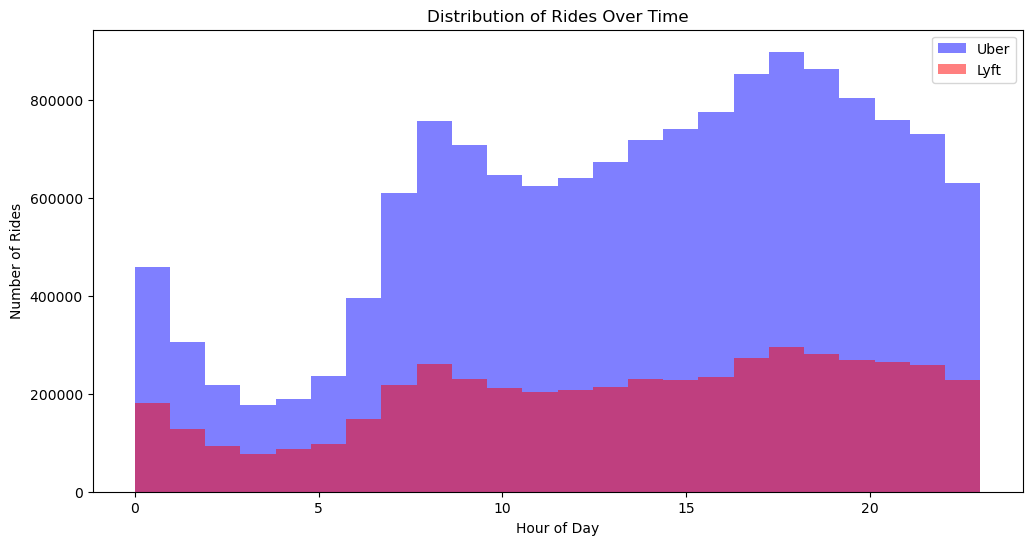

Uber:
Total Rides: 14419623
Average Trip Distance: 4.99 miles
Average Trip Duration: 18.89 minutes

Lyft:
Total Rides: 4919838
Average Trip Distance: 4.66 miles
Average Trip Duration: 18.67 minutes


In [6]:
import matplotlib.pyplot as plt

# Filter data for Uber and Lyft
uber_data = df[df['company'] == 'Uber']
lyft_data = df[df['company'] == 'Lyft']

# Calculate total number of rides
uber_rides = len(uber_data)
lyft_rides = len(lyft_data)

# Calculate average trip distance (assuming a 'trip_distance' column exists)
uber_avg_distance = uber_data['trip_miles'].mean()
lyft_avg_distance = lyft_data['trip_miles'].mean()

# Calculate average trip duration (assuming 'pickup_datetime' and 'dropoff_datetime' columns exist)
uber_data['trip_duration'] = (pd.to_datetime(uber_data['dropoff_datetime']) - pd.to_datetime(uber_data['pickup_datetime'])).dt.total_seconds() / 60
lyft_data['trip_duration'] = (pd.to_datetime(lyft_data['dropoff_datetime']) - pd.to_datetime(lyft_data['pickup_datetime'])).dt.total_seconds() / 60

uber_avg_duration = uber_data['trip_duration'].mean()
lyft_avg_duration = lyft_data['trip_duration'].mean()

# Plot distribution of rides over time (e.g., hourly)
uber_data['hour'] = pd.to_datetime(uber_data['pickup_datetime']).dt.hour
lyft_data['hour'] = pd.to_datetime(lyft_data['pickup_datetime']).dt.hour

plt.figure(figsize=(12, 6))
plt.hist(uber_data['hour'], bins=24, alpha=0.5, label='Uber', color='blue')
plt.hist(lyft_data['hour'], bins=24, alpha=0.5, label='Lyft', color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Distribution of Rides Over Time')
plt.legend()
plt.show()

# Print summary statistics
print("Uber:")
print(f"Total Rides: {uber_rides}")
print(f"Average Trip Distance: {uber_avg_distance:.2f} miles")
print(f"Average Trip Duration: {uber_avg_duration:.2f} minutes")

print("\nLyft:")
print(f"Total Rides: {lyft_rides}")
print(f"Average Trip Distance: {lyft_avg_distance:.2f} miles")
print(f"Average Trip Duration: {lyft_avg_duration:.2f} minutes")

Column: hvfhs_license_num
  Uber - Mean: None, Median: None, Unique Values: 1
  Lyft - Mean: None, Median: None, Unique Values: 1

Column: dispatching_base_num
  Uber - Mean: None, Median: None, Unique Values: 1
  Lyft - Mean: None, Median: None, Unique Values: 1

Column: originating_base_num
  Uber - Mean: None, Median: None, Unique Values: 3
  Lyft - Mean: None, Median: None, Unique Values: 2

Column: request_datetime
  Uber - Mean: None, Median: None, Unique Values: 2316515
  Lyft - Mean: None, Median: None, Unique Values: 1963300

Column: on_scene_datetime
  Uber - Mean: None, Median: None, Unique Values: 2322731
  Lyft - Mean: None, Median: None, Unique Values: 13408

Column: pickup_datetime
  Uber - Mean: None, Median: None, Unique Values: 2322607
  Lyft - Mean: None, Median: None, Unique Values: 1971287

Column: dropoff_datetime
  Uber - Mean: None, Median: None, Unique Values: 2323071
  Lyft - Mean: None, Median: None, Unique Values: 1975988

Column: PULocationID
  Uber - Mean:

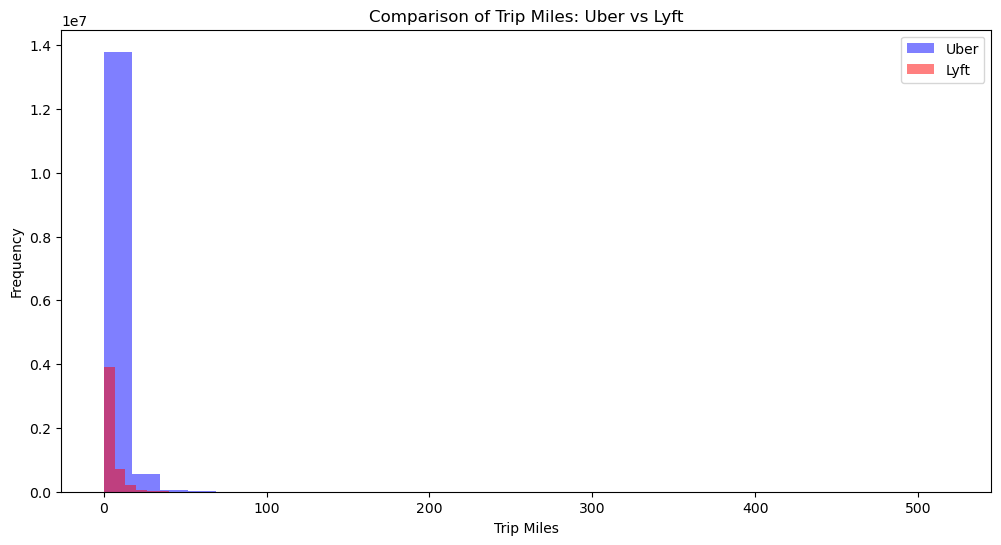

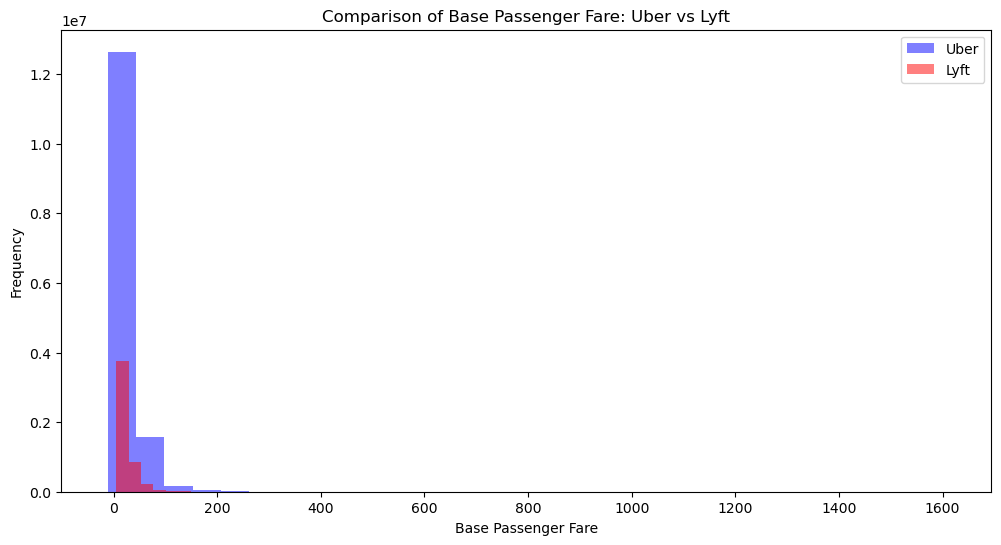

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter data for Uber and Lyft
uber_data = df[df['company'] == 'Uber']
lyft_data = df[df['company'] == 'Lyft']

# Define columns to analyze
columns_to_compare = [
    'hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
    'request_datetime', 'on_scene_datetime', 'pickup_datetime',
    'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
    'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
    'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
    'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
    'wav_request_flag', 'wav_match_flag', 'cbd_congestion_fee'
]

# Initialize a dictionary to store summary statistics
comparison_summary = {}

# Loop through each column and calculate statistics
for column in columns_to_compare:
    if column in uber_data.columns and column in lyft_data.columns:
        comparison_summary[column] = {
            'Uber': {
                'mean': uber_data[column].mean() if pd.api.types.is_numeric_dtype(uber_data[column]) else None,
                'median': uber_data[column].median() if pd.api.types.is_numeric_dtype(uber_data[column]) else None,
                'unique_values': uber_data[column].nunique() if not pd.api.types.is_numeric_dtype(uber_data[column]) else None
            },
            'Lyft': {
                'mean': lyft_data[column].mean() if pd.api.types.is_numeric_dtype(lyft_data[column]) else None,
                'median': lyft_data[column].median() if pd.api.types.is_numeric_dtype(lyft_data[column]) else None,
                'unique_values': lyft_data[column].nunique() if not pd.api.types.is_numeric_dtype(lyft_data[column]) else None
            }
        }

# Display summary statistics for each column
for column, stats in comparison_summary.items():
    print(f"Column: {column}")
    print(f"  Uber - Mean: {stats['Uber']['mean']}, Median: {stats['Uber']['median']}, Unique Values: {stats['Uber']['unique_values']}")
    print(f"  Lyft - Mean: {stats['Lyft']['mean']}, Median: {stats['Lyft']['median']}, Unique Values: {stats['Lyft']['unique_values']}")
    print()

# Example visualization: Compare trip miles
plt.figure(figsize=(12, 6))
plt.hist(uber_data['trip_miles'], bins=30, alpha=0.5, label='Uber', color='blue')
plt.hist(lyft_data['trip_miles'], bins=30, alpha=0.5, label='Lyft', color='red')
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Comparison of Trip Miles: Uber vs Lyft')
plt.legend()
plt.show()

# Example visualization: Compare base passenger fare
plt.figure(figsize=(12, 6))
plt.hist(uber_data['base_passenger_fare'], bins=30, alpha=0.5, label='Uber', color='blue')
plt.hist(lyft_data['base_passenger_fare'], bins=30, alpha=0.5, label='Lyft', color='red')
plt.xlabel('Base Passenger Fare')
plt.ylabel('Frequency')
plt.title('Comparison of Base Passenger Fare: Uber vs Lyft')
plt.legend()
plt.show()

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def calculate_minimum_fleet_size_first_hour(company_data, company_name):
    """
    Calculate minimum fleet size for the first hour based on time and location constraints.
    A vehicle cannot be in two places at the same time or serve overlapping trips.
    """
    print(f"\n=== Calculating Minimum Fleet Size for {company_name} (First Hour Analysis) ===")
    
    # Convert datetime columns
    company_data = company_data.copy()
    company_data['pickup_datetime'] = pd.to_datetime(company_data['pickup_datetime'])
    company_data['dropoff_datetime'] = pd.to_datetime(company_data['dropoff_datetime'])
    
    # Get the first hour of data
    start_time = company_data['pickup_datetime'].min().floor('H')
    end_time = start_time + pd.Timedelta(hours=1)
    
    print(f"Analyzing period: {start_time} to {end_time}")
    
    # Filter trips that start in the first hour
    first_hour_trips = company_data[
        (company_data['pickup_datetime'] >= start_time) & 
        (company_data['pickup_datetime'] < end_time)
    ].copy()
    
    print(f"Total trips starting in first hour: {len(first_hour_trips)}")
    
    # Sort by pickup time
    first_hour_trips = first_hour_trips.sort_values('pickup_datetime').reset_index(drop=True)
    
    # Calculate minimum fleet size using a greedy algorithm
    # Each vehicle can only serve one trip at a time
    vehicles = []  # List of vehicle end times and locations
    trip_assignments = []
    
    for idx, trip in first_hour_trips.iterrows():
        pickup_time = trip['pickup_datetime']
        dropoff_time = trip['dropoff_datetime']
        pickup_location = trip['PULocationID']
        dropoff_location = trip['DOLocationID']
        
        # Find an available vehicle
        assigned_vehicle = None
        
        for i, vehicle in enumerate(vehicles):
            vehicle_end_time, vehicle_last_location = vehicle
            
            # Vehicle is available if:
            # 1. It finished its last trip before this pickup
            # 2. It's at the same location as pickup (or we assume repositioning time)
            if vehicle_end_time <= pickup_time:
                # For simplicity, assume vehicle can reposition instantly
                # In reality, you'd add travel time between locations
                assigned_vehicle = i
                break
        
        if assigned_vehicle is not None:
            # Update existing vehicle
            vehicles[assigned_vehicle] = (dropoff_time, dropoff_location)
            trip_assignments.append({
                'trip_index': idx,
                'vehicle_id': assigned_vehicle,
                'pickup_time': pickup_time,
                'dropoff_time': dropoff_time,
                'pickup_location': pickup_location,
                'dropoff_location': dropoff_location
            })
        else:
            # Need a new vehicle
            vehicle_id = len(vehicles)
            vehicles.append((dropoff_time, dropoff_location))
            trip_assignments.append({
                'trip_index': idx,
                'vehicle_id': vehicle_id,
                'pickup_time': pickup_time,
                'dropoff_time': dropoff_time,
                'pickup_location': pickup_location,
                'dropoff_location': dropoff_location
            })
    
    min_fleet_size = len(vehicles)
    
    print(f"Minimum fleet size needed: {min_fleet_size} vehicles")
    print(f"Average trips per vehicle: {len(first_hour_trips) / min_fleet_size:.2f}")
    
    # Create assignment dataframe for analysis
    assignments_df = pd.DataFrame(trip_assignments)
    
    # Show vehicle utilization
    if len(assignments_df) > 0:
        vehicle_stats = assignments_df.groupby('vehicle_id').agg({
            'trip_index': 'count',
            'pickup_time': ['min', 'max'],
            'dropoff_time': 'max'
        }).round(2)
        
        vehicle_stats.columns = ['num_trips', 'first_pickup', 'last_pickup', 'last_dropoff']
        
        print(f"\nVehicle utilization summary:")
        print(vehicle_stats.head(10))
        
        # Calculate busy time for each vehicle
        vehicle_stats['busy_duration_minutes'] = (
            vehicle_stats['last_dropoff'] - vehicle_stats['first_pickup']
        ).dt.total_seconds() / 60
        
        print(f"\nAverage busy time per vehicle: {vehicle_stats['busy_duration_minutes'].mean():.1f} minutes")
        print(f"Maximum busy time: {vehicle_stats['busy_duration_minutes'].max():.1f} minutes")
    
    return {
        'min_fleet_size': min_fleet_size,
        'total_trips': len(first_hour_trips),
        'assignments': assignments_df,
        'period_start': start_time,
        'period_end': end_time
    }

# Calculate minimum fleet sizes for both companies (first hour only)
uber_data = df[df['company'] == 'Uber'].copy()
lyft_data = df[df['company'] == 'Lyft'].copy()

print(f"Total Uber trips in dataset: {len(uber_data):,}")
print(f"Total Lyft trips in dataset: {len(lyft_data):,}")

# Analyze first hour for both companies
uber_first_hour = calculate_minimum_fleet_size_first_hour(uber_data, 'Uber')
lyft_first_hour = calculate_minimum_fleet_size_first_hour(lyft_data, 'Lyft')

Total Uber trips in dataset: 14,419,623
Total Lyft trips in dataset: 4,919,838

=== Calculating Minimum Fleet Size for Uber (First Hour Analysis) ===


/var/folders/cn/fgq6fx4941j6hk598s_2v6t00000gn/T/ipykernel_51940/1603409211.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = company_data['pickup_datetime'].min().floor('H')


Analyzing period: 2025-02-01 00:00:00 to 2025-02-01 01:00:00
Total trips starting in first hour: 24020
Minimum fleet size needed: 7125 vehicles
Average trips per vehicle: 3.37

Vehicle utilization summary:
            num_trips        first_pickup         last_pickup  \
vehicle_id                                                      
0                   5 2025-02-01 00:00:00 2025-02-01 00:58:57   
1                   3 2025-02-01 00:00:00 2025-02-01 00:39:32   
2                   3 2025-02-01 00:00:00 2025-02-01 00:58:24   
3                   5 2025-02-01 00:00:01 2025-02-01 00:47:36   
4                   3 2025-02-01 00:00:01 2025-02-01 00:38:16   
5                   5 2025-02-01 00:00:01 2025-02-01 00:52:21   
6                   3 2025-02-01 00:00:01 2025-02-01 00:43:17   
7                   4 2025-02-01 00:00:01 2025-02-01 00:49:30   
8                   5 2025-02-01 00:00:01 2025-02-01 00:56:30   
9                   6 2025-02-01 00:00:01 2025-02-01 00:52:37   

             

/var/folders/cn/fgq6fx4941j6hk598s_2v6t00000gn/T/ipykernel_51940/1603409211.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = company_data['pickup_datetime'].min().floor('H')


Analyzing period: 2025-02-01 00:00:00 to 2025-02-01 01:00:00
Total trips starting in first hour: 9711
Minimum fleet size needed: 2795 vehicles
Average trips per vehicle: 3.47

Vehicle utilization summary:
            num_trips        first_pickup         last_pickup  \
vehicle_id                                                      
0                   4 2025-02-01 00:00:01 2025-02-01 00:53:20   
1                   2 2025-02-01 00:00:02 2025-02-01 00:07:35   
2                   4 2025-02-01 00:00:02 2025-02-01 00:45:50   
3                   4 2025-02-01 00:00:02 2025-02-01 00:52:13   
4                   5 2025-02-01 00:00:02 2025-02-01 00:43:17   
5                   3 2025-02-01 00:00:02 2025-02-01 00:55:58   
6                   5 2025-02-01 00:00:03 2025-02-01 00:50:51   
7                   3 2025-02-01 00:00:03 2025-02-01 00:49:57   
8                   4 2025-02-01 00:00:04 2025-02-01 00:51:16   
9                   4 2025-02-01 00:00:04 2025-02-01 00:56:06   

              

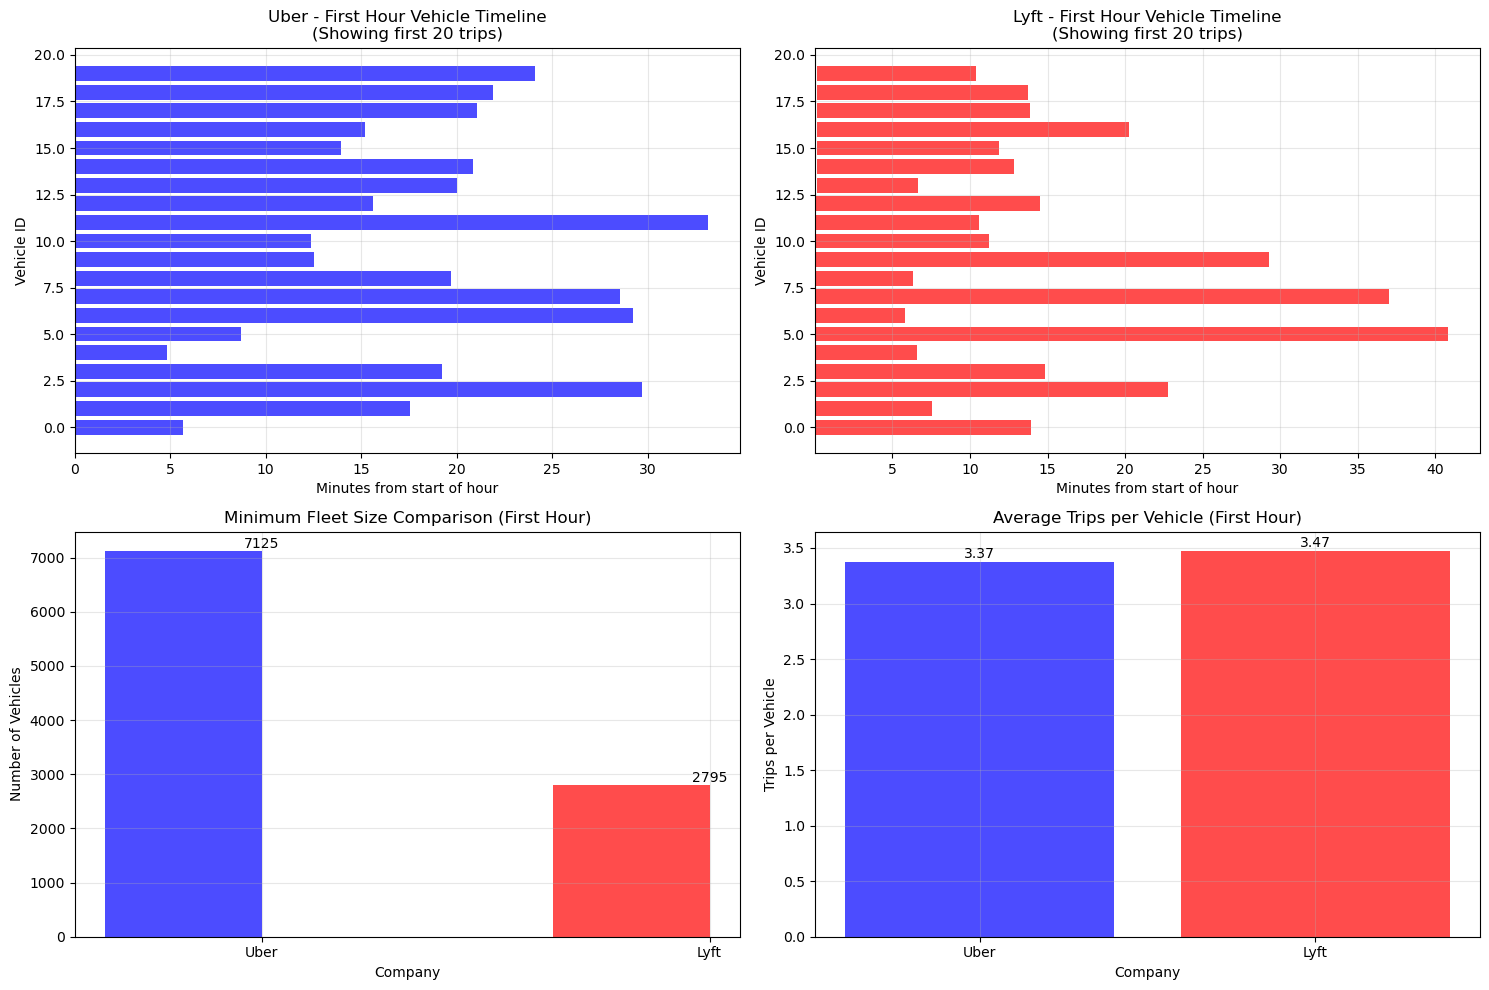


=== First Hour Fleet Analysis Summary ===
Period analyzed: 2025-02-01 00:00:00 to 2025-02-01 01:00:00

Uber:
  Trips in first hour: 24,020
  Minimum fleet size: 7125 vehicles
  Trips per vehicle: 3.37

Lyft:
  Trips in first hour: 9,711
  Minimum fleet size: 2795 vehicles
  Trips per vehicle: 3.47

Efficiency Comparison:
  Uber efficiency: 3.37 trips/vehicle
  Lyft efficiency: 3.47 trips/vehicle


In [14]:
# Visualize the first hour analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Trip timeline for Uber (first 20 trips)
if len(uber_first_hour['assignments']) > 0:
    uber_sample = uber_first_hour['assignments'].head(20)
    for idx, trip in uber_sample.iterrows():
        y_pos = trip['vehicle_id']
        axes[0,0].barh(y_pos, 
                      (trip['dropoff_time'] - trip['pickup_time']).total_seconds() / 60,
                      left=(trip['pickup_time'] - uber_first_hour['period_start']).total_seconds() / 60,
                      height=0.8, alpha=0.7, color='blue')
    
    axes[0,0].set_title(f'Uber - First Hour Vehicle Timeline\n(Showing first 20 trips)')
    axes[0,0].set_xlabel('Minutes from start of hour')
    axes[0,0].set_ylabel('Vehicle ID')
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Trip timeline for Lyft (first 20 trips)
if len(lyft_first_hour['assignments']) > 0:
    lyft_sample = lyft_first_hour['assignments'].head(20)
    for idx, trip in lyft_sample.iterrows():
        y_pos = trip['vehicle_id']
        axes[0,1].barh(y_pos, 
                      (trip['dropoff_time'] - trip['pickup_time']).total_seconds() / 60,
                      left=(trip['pickup_time'] - lyft_first_hour['period_start']).total_seconds() / 60,
                      height=0.8, alpha=0.7, color='red')
    
    axes[0,1].set_title(f'Lyft - First Hour Vehicle Timeline\n(Showing first 20 trips)')
    axes[0,1].set_xlabel('Minutes from start of hour')
    axes[0,1].set_ylabel('Vehicle ID')
    axes[0,1].grid(True, alpha=0.3)

# Plot 3: Fleet size comparison
companies = ['Uber', 'Lyft']
fleet_sizes = [uber_first_hour['min_fleet_size'], lyft_first_hour['min_fleet_size']]
trip_counts = [uber_first_hour['total_trips'], lyft_first_hour['total_trips']]

x = np.arange(len(companies))
width = 0.35

axes[1,0].bar(x - width/2, fleet_sizes, width, label='Min Fleet Size', color=['blue', 'red'], alpha=0.7)
axes[1,0].set_title('Minimum Fleet Size Comparison (First Hour)')
axes[1,0].set_xlabel('Company')
axes[1,0].set_ylabel('Number of Vehicles')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(companies)
axes[1,0].grid(True, alpha=0.3)

for i, v in enumerate(fleet_sizes):
    axes[1,0].text(i, v + 0.01, str(v), ha='center', va='bottom')

# Plot 4: Trips per vehicle
if uber_first_hour['min_fleet_size'] > 0 and lyft_first_hour['min_fleet_size'] > 0:
    trips_per_vehicle = [
        uber_first_hour['total_trips'] / uber_first_hour['min_fleet_size'],
        lyft_first_hour['total_trips'] / lyft_first_hour['min_fleet_size']
    ]
    
    axes[1,1].bar(x, trips_per_vehicle, color=['blue', 'red'], alpha=0.7)
    axes[1,1].set_title('Average Trips per Vehicle (First Hour)')
    axes[1,1].set_xlabel('Company')
    axes[1,1].set_ylabel('Trips per Vehicle')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(companies)
    axes[1,1].grid(True, alpha=0.3)
    
    for i, v in enumerate(trips_per_vehicle):
        axes[1,1].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary comparison
print(f"\n=== First Hour Fleet Analysis Summary ===")
print(f"Period analyzed: {uber_first_hour['period_start']} to {uber_first_hour['period_end']}")
print(f"\nUber:")
print(f"  Trips in first hour: {uber_first_hour['total_trips']:,}")
print(f"  Minimum fleet size: {uber_first_hour['min_fleet_size']} vehicles")
print(f"  Trips per vehicle: {uber_first_hour['total_trips'] / uber_first_hour['min_fleet_size']:.2f}")

print(f"\nLyft:")
print(f"  Trips in first hour: {lyft_first_hour['total_trips']:,}")
print(f"  Minimum fleet size: {lyft_first_hour['min_fleet_size']} vehicles")
print(f"  Trips per vehicle: {lyft_first_hour['total_trips'] / lyft_first_hour['min_fleet_size']:.2f}")

print(f"\nEfficiency Comparison:")
print(f"  Uber efficiency: {(uber_first_hour['total_trips'] / uber_first_hour['min_fleet_size']) if uber_first_hour['min_fleet_size'] > 0 else 0:.2f} trips/vehicle")
print(f"  Lyft efficiency: {(lyft_first_hour['total_trips'] / lyft_first_hour['min_fleet_size']) if lyft_first_hour['min_fleet_size'] > 0 else 0:.2f} trips/vehicle")

Loaded 263 taxi zones
Columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']
CRS: EPSG:2263

First 5 taxi zones:
   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 1

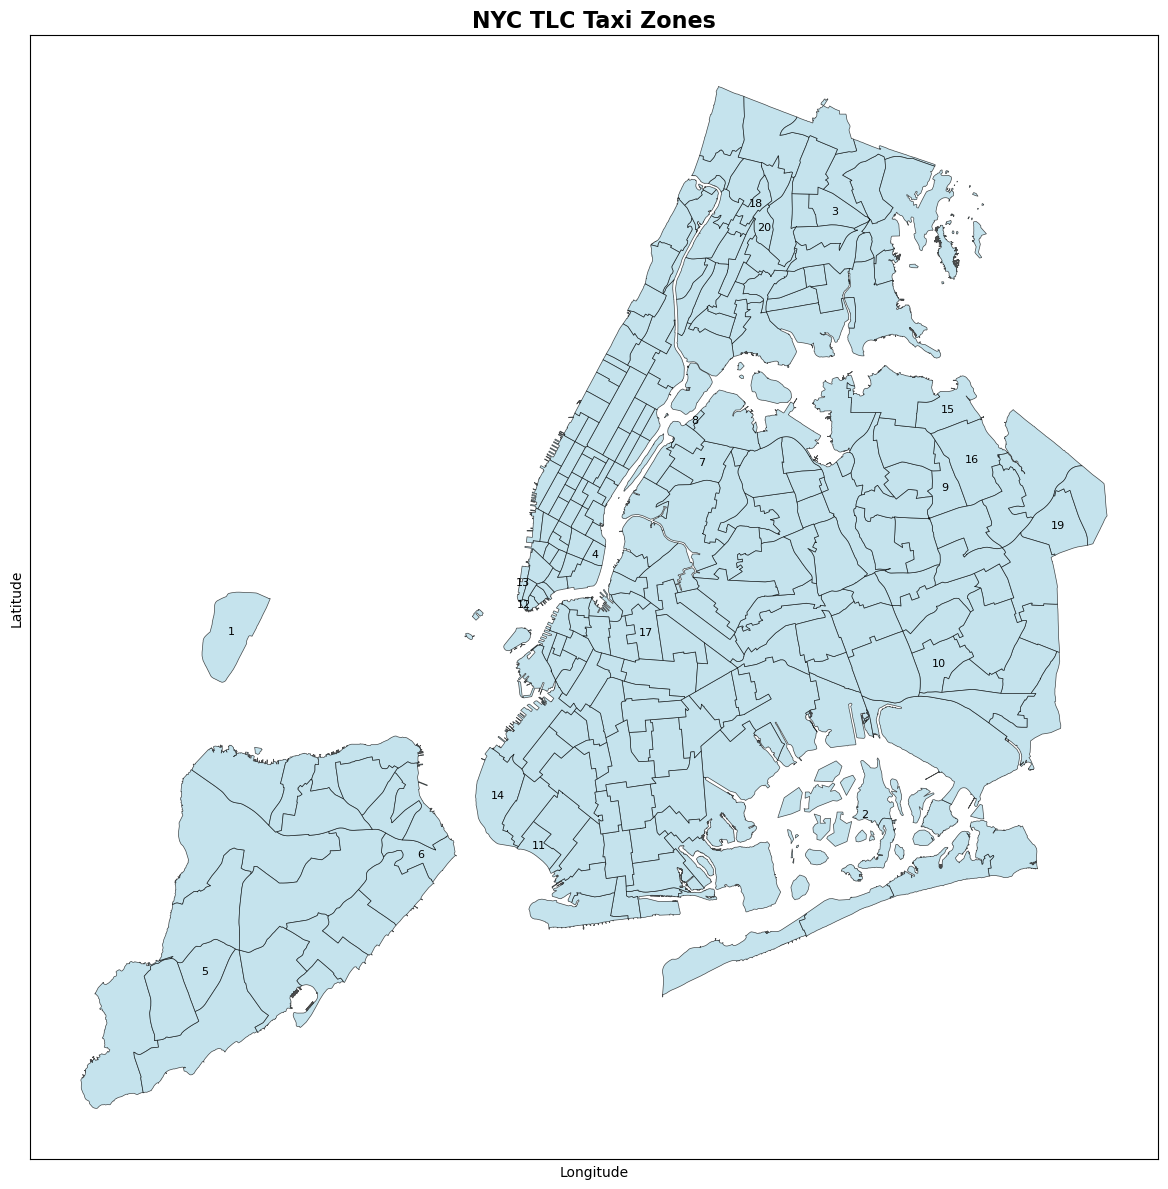


Creating interactive map...
Interactive map saved as nyc_taxi_zones_map.html

=== Taxi Zones Statistics ===
Total number of zones: 263

Zones by borough:
borough
Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: count, dtype: int64

Area statistics:
Largest zone: 34.13 km²
Smallest zone: 0.10 km²
Average zone size: 5.25 km²
Interactive map saved as nyc_taxi_zones_map.html

=== Taxi Zones Statistics ===
Total number of zones: 263

Zones by borough:
borough
Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: count, dtype: int64

Area statistics:
Largest zone: 34.13 km²
Smallest zone: 0.10 km²
Average zone size: 5.25 km²


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import json

# Load TLC Taxi Zones data
# Assuming the taxi zones folder contains a shapefile with taxi zone boundaries
taxi_zones_path = 'taxi_zones/taxi_zones.shp'  # Adjust path as needed

try:
    # Load the taxi zones shapefile
    taxi_zones = gpd.read_file(taxi_zones_path)
    print(f"Loaded {len(taxi_zones)} taxi zones")
    print(f"Columns: {taxi_zones.columns.tolist()}")
    print(f"CRS: {taxi_zones.crs}")
    
    # Display first few rows
    print("\nFirst 5 taxi zones:")
    print(taxi_zones.head())
    
except FileNotFoundError:
    print(f"Taxi zones file not found at {taxi_zones_path}")
    print("Please check the file path and ensure the shapefile exists")
    
    # Try alternative paths
    alternative_paths = [
        '../taxi_zones/taxi_zones.geojson',
        '../taxi_zones/nyc_taxi_zones.shp',
        './taxi_zones/taxi_zones.shp'
    ]
    
    for alt_path in alternative_paths:
        try:
            taxi_zones = gpd.read_file(alt_path)
            print(f"Successfully loaded from alternative path: {alt_path}")
            break
        except:
            continue
    else:
        print("Could not find taxi zones data in any expected location")
        taxi_zones = None

if taxi_zones is not None:
    # Convert to WGS84 for mapping
    if taxi_zones.crs != 'EPSG:4326':
        taxi_zones = taxi_zones.to_crs('EPSG:4326')
    
    # Create matplotlib visualization
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    
    # Plot taxi zones
    taxi_zones.plot(ax=ax, 
                   color='lightblue', 
                   edgecolor='black', 
                   linewidth=0.5, 
                   alpha=0.7)
    
    # Add zone labels for major areas (if LocationID column exists)
    if 'LocationID' in taxi_zones.columns:
        # Add labels for some zones
        for idx, row in taxi_zones.head(20).iterrows():
            centroid = row.geometry.centroid
            ax.annotate(str(row['LocationID']), 
                       xy=(centroid.x, centroid.y),
                       fontsize=8, 
                       ha='center',
                       va='center')
    
    ax.set_title('NYC TLC Taxi Zones', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, alpha=0.3)
    
    # Remove axes ticks for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Create interactive folium map
    print("\nCreating interactive map...")
    
    # Calculate map center
    bounds = taxi_zones.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create folium map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=10,
        tiles='OpenStreetMap'
    )
    
    # Add taxi zones to map
    folium.GeoJson(
        taxi_zones.to_json(),
        style_function=lambda feature: {
            'fillColor': 'lightblue',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.3,
        },
        popup=folium.GeoJsonPopup(
            fields=['LocationID', 'zone'] if 'zone' in taxi_zones.columns else ['LocationID'],
            aliases=['Zone ID:', 'Zone Name:'] if 'zone' in taxi_zones.columns else ['Zone ID:'],
            localize=True,
            labels=True,
            style="background-color: white;",
        ),
        tooltip=folium.GeoJsonTooltip(
            fields=['LocationID', 'zone'] if 'zone' in taxi_zones.columns else ['LocationID'],
            aliases=['Zone ID:', 'Zone Name:'] if 'zone' in taxi_zones.columns else ['Zone ID:'],
            localize=True,
            sticky=False,
            labels=True,
            style="""
                background-color: #F0EFEF;
                border: 2px solid black;
                border-radius: 3px;
                box-shadow: 3px;
            """,
            max_width=800,
        )
    ).add_to(m)
    
    # Add a marker for Manhattan
    folium.Marker(
        [40.7831, -73.9712],
        popup="Manhattan",
        tooltip="Manhattan",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Save map
    map_filename = 'nyc_taxi_zones_map.html'
    m.save(map_filename)
    print(f"Interactive map saved as {map_filename}")
    
    # Display basic statistics
    print(f"\n=== Taxi Zones Statistics ===")
    print(f"Total number of zones: {len(taxi_zones)}")
    
    if 'borough' in taxi_zones.columns:
        print(f"\nZones by borough:")
        borough_counts = taxi_zones['borough'].value_counts()
        print(borough_counts)
    
    # Calculate areas (in projected coordinate system)
    taxi_zones_proj = taxi_zones.to_crs('EPSG:3857')  # Web Mercator for area calculation
    taxi_zones_proj['area_sq_km'] = taxi_zones_proj.geometry.area / 1e6  # Convert to km²
    
    print(f"\nArea statistics:")
    print(f"Largest zone: {taxi_zones_proj['area_sq_km'].max():.2f} km²")
    print(f"Smallest zone: {taxi_zones_proj['area_sq_km'].min():.2f} km²")
    print(f"Average zone size: {taxi_zones_proj['area_sq_km'].mean():.2f} km²")
    
else:
    print("Cannot create visualizations without taxi zones data")
    print("Please ensure the taxi zones shapefile is available in the correct location")

In [5]:
import pandas as pd
import numpy as np
import pickle
import json
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
import networkx as nx

def calculate_zone_travel_times(df, taxi_zones):
    """
    Calculate average travel times between all taxi zones efficiently.
    Handle missing connections using geographic distance and network interpolation.
    """
    print("=== Calculating Travel Times Between Taxi Zones ===")
    
    # Filter valid trips with both pickup and dropoff locations
    valid_trips = df[
        (df['PULocationID'].notna()) & 
        (df['DOLocationID'].notna()) &
        (df['trip_time'] > 0) &
        (df['trip_time'] < 7200)  # Remove trips longer than 2 hours (likely errors)
    ].copy()
    
    print(f"Valid trips for analysis: {len(valid_trips):,}")
    
    # Convert trip_time from seconds to minutes
    valid_trips['trip_duration_minutes'] = valid_trips['trip_time'] / 60
    
    # Group by origin-destination pairs and calculate statistics
    print("Calculating direct travel times from ride data...")
    travel_stats = valid_trips.groupby(['PULocationID', 'DOLocationID']).agg({
        'trip_duration_minutes': ['mean', 'median', 'std', 'count'],
        'trip_miles': ['mean', 'median']
    }).round(2)
    
    # Flatten column names
    travel_stats.columns = ['_'.join(col).strip() for col in travel_stats.columns]
    travel_stats = travel_stats.reset_index()
    
    print(f"Direct connections found: {len(travel_stats):,}")
    
    # Get all unique zone IDs from both data and shapefile
    data_zones = set(valid_trips['PULocationID'].unique()) | set(valid_trips['DOLocationID'].unique())
    shapefile_zones = set(taxi_zones['LocationID'].unique()) if 'LocationID' in taxi_zones.columns else set()
    all_zones = sorted(data_zones | shapefile_zones)
    
    print(f"Total zones: {len(all_zones)}")
    print(f"Zones in data: {len(data_zones)}")
    print(f"Zones in shapefile: {len(shapefile_zones)}")
    
    # Create travel time matrix
    n_zones = len(all_zones)
    zone_to_idx = {zone: idx for idx, zone in enumerate(all_zones)}
    
    # Initialize matrices
    travel_time_matrix = np.full((n_zones, n_zones), np.nan)
    trip_count_matrix = np.zeros((n_zones, n_zones))
    distance_matrix = np.full((n_zones, n_zones), np.nan)
    
    # Fill matrices with direct connections
    for _, row in travel_stats.iterrows():
        origin_idx = zone_to_idx[row['PULocationID']]
        dest_idx = zone_to_idx[row['DOLocationID']]
        travel_time_matrix[origin_idx, dest_idx] = row['trip_duration_minutes_mean']
        trip_count_matrix[origin_idx, dest_idx] = row['trip_duration_minutes_count']
        distance_matrix[origin_idx, dest_idx] = row['trip_miles_mean']
    
    # Set diagonal to 0 (same zone)
    np.fill_diagonal(travel_time_matrix, 0)
    np.fill_diagonal(distance_matrix, 0)
    
    return {
        'travel_time_matrix': travel_time_matrix,
        'trip_count_matrix': trip_count_matrix,
        'distance_matrix': distance_matrix,
        'zone_ids': all_zones,
        'zone_to_idx': zone_to_idx,
        'travel_stats': travel_stats
    }

def handle_missing_connections(travel_data, taxi_zones):
    """
    Handle missing connections using multiple strategies:
    1. Geographic distance-based estimation
    2. Network shortest path through existing connections
    3. Speed-based estimation from existing data
    """
    print("\n=== Handling Missing Connections ===")
    
    travel_time_matrix = travel_data['travel_time_matrix'].copy()
    distance_matrix = travel_data['distance_matrix'].copy()
    zone_ids = travel_data['zone_ids']
    zone_to_idx = travel_data['zone_to_idx']
    
    # Calculate geographic distances between zone centroids
    if 'LocationID' in taxi_zones.columns and 'geometry' in taxi_zones.columns:
        print("Calculating geographic distances...")
        
        # Get centroids for zones in our data
        zone_centroids = {}
        for _, row in taxi_zones.iterrows():
            if row['LocationID'] in zone_ids:
                centroid = row['geometry'].centroid
                zone_centroids[row['LocationID']] = (centroid.x, centroid.y)
        
        # Calculate Euclidean distances between centroids
        coords = []
        valid_zones = []
        for zone_id in zone_ids:
            if zone_id in zone_centroids:
                coords.append(zone_centroids[zone_id])
                valid_zones.append(zone_id)
        
        if len(coords) > 1:
            coords = np.array(coords)
            euclidean_distances = cdist(coords, coords, metric='euclidean')
            
            # Convert to approximate Manhattan distance (multiply by ~1.3)
            manhattan_distances = euclidean_distances * 1.3
            
            # Estimate average speed from existing data
            valid_mask = ~np.isnan(travel_time_matrix) & ~np.isnan(distance_matrix) & (distance_matrix > 0)
            if np.any(valid_mask):
                speeds = distance_matrix[valid_mask] / (travel_time_matrix[valid_mask] / 60)  # mph
                avg_speed = np.median(speeds[speeds > 0])
                print(f"Estimated average speed: {avg_speed:.2f} mph")
            else:
                avg_speed = 12.0  # Default NYC taxi speed
                print(f"Using default speed: {avg_speed:.2f} mph")
            
            # Fill missing connections with distance-based estimates
            for i, zone1 in enumerate(valid_zones):
                for j, zone2 in enumerate(valid_zones):
                    zone1_idx = zone_to_idx[zone1]
                    zone2_idx = zone_to_idx[zone2]
                    
                    if np.isnan(travel_time_matrix[zone1_idx, zone2_idx]) and zone1 != zone2:
                        # Estimate travel time based on distance and average speed
                        distance_miles = manhattan_distances[i, j] * 69  # Convert degrees to miles (rough)
                        estimated_time = (distance_miles / avg_speed) * 60  # Convert to minutes
                        
                        # Add some buffer for city driving (traffic, stops, etc.)
                        estimated_time *= 1.5
                        
                        travel_time_matrix[zone1_idx, zone2_idx] = estimated_time
                        distance_matrix[zone1_idx, zone2_idx] = distance_miles
    
    # Use network shortest path for remaining missing connections
    print("Using network shortest path for remaining connections...")
    
    # Create a graph from existing connections
    G = nx.DiGraph()
    for i in range(len(zone_ids)):
        for j in range(len(zone_ids)):
            if not np.isnan(travel_time_matrix[i, j]) and i != j:
                G.add_edge(zone_ids[i], zone_ids[j], weight=travel_time_matrix[i, j])
    
    # Fill remaining missing connections using shortest path
    missing_filled = 0
    for i, zone1 in enumerate(zone_ids):
        for j, zone2 in enumerate(zone_ids):
            if np.isnan(travel_time_matrix[i, j]) and zone1 != zone2:
                try:
                    shortest_path_time = nx.shortest_path_length(G, zone1, zone2, weight='weight')
                    travel_time_matrix[i, j] = shortest_path_time
                    missing_filled += 1
                except nx.NetworkXNoPath:
                    # If no path exists, use a high default value
                    travel_time_matrix[i, j] = 120.0  # 2 hours default
    
    print(f"Filled {missing_filled} connections using shortest path")
    
    # Final check: ensure no NaN values remain
    remaining_nan = np.sum(np.isnan(travel_time_matrix))
    if remaining_nan > 0:
        print(f"Warning: {remaining_nan} connections still missing, filling with default values")
        travel_time_matrix = np.nan_to_num(travel_time_matrix, nan=120.0)
    
    return travel_time_matrix, distance_matrix

def save_travel_time_data(travel_data, travel_time_matrix, distance_matrix, filename_base='zone_travel_times'):
    """
    Save travel time data in multiple formats for easy access.
    """
    print(f"\n=== Saving Travel Time Data ===")
    
    # Save as pickle (most efficient for Python)
    pickle_data = {
        'travel_time_matrix': travel_time_matrix,
        'distance_matrix': distance_matrix,
        'zone_ids': travel_data['zone_ids'],
        'zone_to_idx': travel_data['zone_to_idx'],
        'trip_count_matrix': travel_data['trip_count_matrix'],
        'travel_stats': travel_data['travel_stats']
    }
    
    with open(f'{filename_base}.pkl', 'wb') as f:
        pickle.dump(pickle_data, f)
    print(f"Saved pickle file: {filename_base}.pkl")
    
    # Save as CSV for easy viewing
    zone_ids = travel_data['zone_ids']
    travel_df = pd.DataFrame(travel_time_matrix, index=zone_ids, columns=zone_ids)
    travel_df.to_csv(f'{filename_base}.csv')
    print(f"Saved CSV file: {filename_base}.csv")
    
    # Save metadata as JSON
    metadata = {
        'n_zones': len(zone_ids),
        'n_direct_connections': int(np.sum(travel_data['trip_count_matrix'] > 0)),
        'avg_travel_time': float(np.mean(travel_time_matrix[travel_time_matrix > 0])),
        'max_travel_time': float(np.max(travel_time_matrix)),
        'creation_date': pd.Timestamp.now().isoformat()
    }
    
    with open(f'{filename_base}_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Saved metadata: {filename_base}_metadata.json")
    
    return pickle_data

# Calculate travel times
if taxi_zones is not None:
    travel_data = calculate_zone_travel_times(df, taxi_zones)
    
    # Handle missing connections
    complete_travel_matrix, complete_distance_matrix = handle_missing_connections(travel_data, taxi_zones)
    
    # Save the data
    saved_data = save_travel_time_data(travel_data, complete_travel_matrix, complete_distance_matrix)
    
    # Display summary statistics
    print(f"\n=== Travel Time Matrix Summary ===")
    print(f"Matrix size: {complete_travel_matrix.shape}")
    print(f"Total possible connections: {len(travel_data['zone_ids'])**2}")
    print(f"Direct connections from data: {int(np.sum(travel_data['trip_count_matrix'] > 0))}")
    print(f"Coverage: {(np.sum(travel_data['trip_count_matrix'] > 0) / len(travel_data['zone_ids'])**2 * 100):.1f}%")
    print(f"Average travel time: {np.mean(complete_travel_matrix[complete_travel_matrix > 0]):.1f} minutes")
    print(f"Median travel time: {np.median(complete_travel_matrix[complete_travel_matrix > 0]):.1f} minutes")
    print(f"Max travel time: {np.max(complete_travel_matrix):.1f} minutes")
    
else:
    print("Cannot calculate travel times without taxi zones data")

=== Calculating Travel Times Between Taxi Zones ===
Valid trips for analysis: 19,335,169
Calculating direct travel times from ride data...
Direct connections found: 59,019
Total zones: 264
Zones in data: 263
Zones in shapefile: 260

=== Handling Missing Connections ===
Calculating geographic distances...
Estimated average speed: 20.85 mph
Using network shortest path for remaining connections...
Filled 1351 connections using shortest path

=== Saving Travel Time Data ===
Saved pickle file: zone_travel_times.pkl
Saved CSV file: zone_travel_times.csv
Saved metadata: zone_travel_times_metadata.json

=== Travel Time Matrix Summary ===
Matrix size: (264, 264)
Total possible connections: 69696
Direct connections from data: 59019
Coverage: 84.7%
Average travel time: 43.4 minutes
Median travel time: 36.8 minutes
Max travel time: 215.1 minutes


=== Creating Travel Time Visualizations ===
Sampling 50 zones for visualization


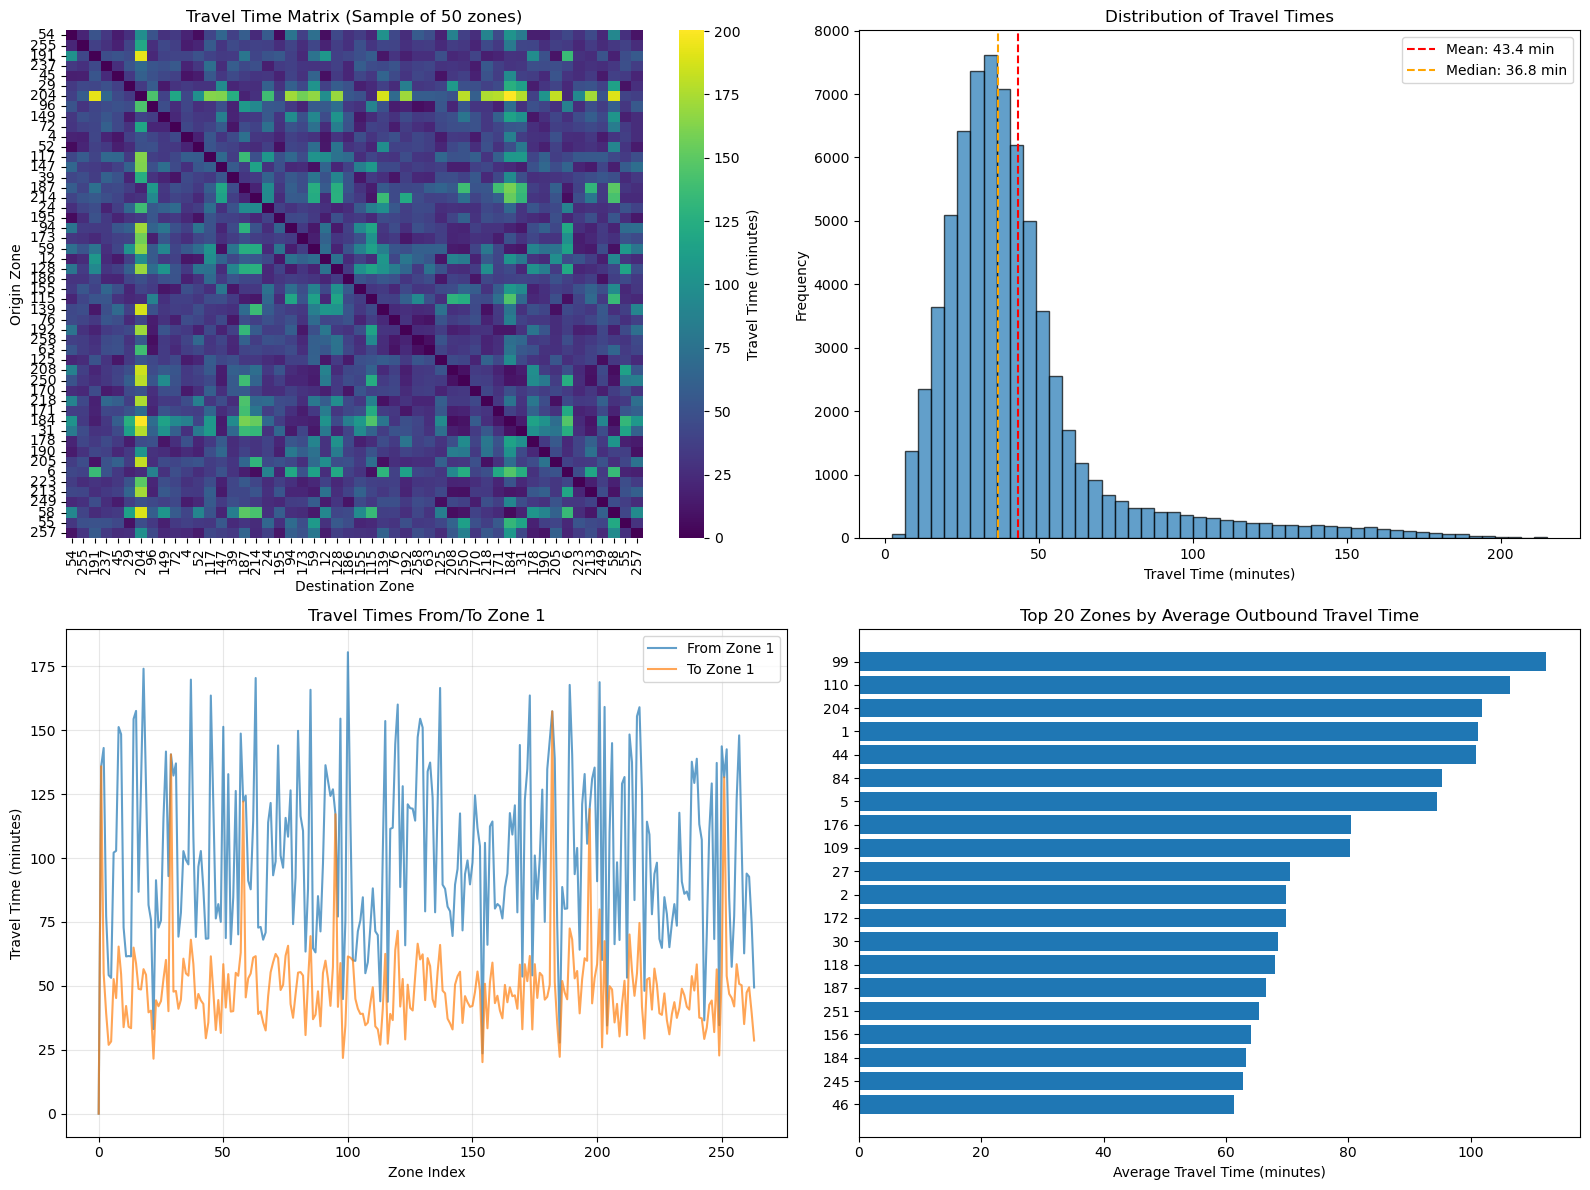


=== Example Usage ===
Travel time from zone 161 to zone 237: 11.5 minutes
Most central zone (shortest avg travel time): Zone 265 (27.8 min avg)


In [6]:
# Create visualizations of the travel time data
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_travel_times(travel_matrix, zone_ids, sample_size=50):
    """
    Create visualizations of the travel time matrix.
    """
    print("=== Creating Travel Time Visualizations ===")
    
    # Sample zones for visualization if matrix is too large
    if len(zone_ids) > sample_size:
        sample_indices = np.random.choice(len(zone_ids), sample_size, replace=False)
        sample_matrix = travel_matrix[np.ix_(sample_indices, sample_indices)]
        sample_zones = [zone_ids[i] for i in sample_indices]
        print(f"Sampling {sample_size} zones for visualization")
    else:
        sample_matrix = travel_matrix
        sample_zones = zone_ids
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Heatmap of travel times (sample)
    sns.heatmap(sample_matrix, 
                xticklabels=sample_zones, 
                yticklabels=sample_zones,
                cmap='viridis', 
                ax=axes[0,0],
                cbar_kws={'label': 'Travel Time (minutes)'})
    axes[0,0].set_title(f'Travel Time Matrix (Sample of {len(sample_zones)} zones)')
    axes[0,0].set_xlabel('Destination Zone')
    axes[0,0].set_ylabel('Origin Zone')
    
    # 2. Distribution of travel times
    travel_times_flat = travel_matrix[travel_matrix > 0].flatten()
    axes[0,1].hist(travel_times_flat, bins=50, edgecolor='black', alpha=0.7)
    axes[0,1].set_title('Distribution of Travel Times')
    axes[0,1].set_xlabel('Travel Time (minutes)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(np.mean(travel_times_flat), color='red', linestyle='--', label=f'Mean: {np.mean(travel_times_flat):.1f} min')
    axes[0,1].axvline(np.median(travel_times_flat), color='orange', linestyle='--', label=f'Median: {np.median(travel_times_flat):.1f} min')
    axes[0,1].legend()
    
    # 3. Travel times from/to specific zones (e.g., Manhattan zones)
    manhattan_zones = [zone for zone in zone_ids if zone <= 100]  # Assuming Manhattan zones have lower IDs
    if manhattan_zones:
        manhattan_zone = manhattan_zones[0]  # Pick first Manhattan zone
        zone_idx = zone_ids.index(manhattan_zone)
        
        # Travel times FROM this zone
        from_zone = travel_matrix[zone_idx, :]
        # Travel times TO this zone
        to_zone = travel_matrix[:, zone_idx]
        
        x = range(len(zone_ids))
        axes[1,0].plot(x, from_zone, label=f'From Zone {manhattan_zone}', alpha=0.7)
        axes[1,0].plot(x, to_zone, label=f'To Zone {manhattan_zone}', alpha=0.7)
        axes[1,0].set_title(f'Travel Times From/To Zone {manhattan_zone}')
        axes[1,0].set_xlabel('Zone Index')
        axes[1,0].set_ylabel('Travel Time (minutes)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Average travel time by zone (outbound)
    avg_outbound = np.mean(travel_matrix, axis=1)
    top_zones = np.argsort(avg_outbound)[-20:]  # Top 20 zones with longest average outbound times
    
    axes[1,1].barh(range(len(top_zones)), avg_outbound[top_zones])
    axes[1,1].set_yticks(range(len(top_zones)))
    axes[1,1].set_yticklabels([zone_ids[i] for i in top_zones])
    axes[1,1].set_title('Top 20 Zones by Average Outbound Travel Time')
    axes[1,1].set_xlabel('Average Travel Time (minutes)')
    
    plt.tight_layout()
    plt.show()

def load_travel_time_data(filename='zone_travel_times.pkl'):
    """
    Load previously saved travel time data.
    """
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Successfully loaded travel time data from {filename}")
        return data
    except FileNotFoundError:
        print(f"File {filename} not found")
        return None

# Visualize the results if we have the data
if 'complete_travel_matrix' in locals():
    visualize_travel_times(complete_travel_matrix, travel_data['zone_ids'])
    
    # Example of how to use the travel time matrix
    print(f"\n=== Example Usage ===")
    zone_to_idx = travel_data['zone_to_idx']
    
    # Example: Travel time from zone 161 to zone 237
    if 161 in zone_to_idx and 237 in zone_to_idx:
        origin_idx = zone_to_idx[161]
        dest_idx = zone_to_idx[237]
        travel_time = complete_travel_matrix[origin_idx, dest_idx]
        print(f"Travel time from zone 161 to zone 237: {travel_time:.1f} minutes")
    
    # Find zones with shortest average travel times (most central)
    avg_travel_times = np.mean(complete_travel_matrix, axis=1)
    most_central_idx = np.argmin(avg_travel_times)
    most_central_zone = travel_data['zone_ids'][most_central_idx]
    print(f"Most central zone (shortest avg travel time): Zone {most_central_zone} ({avg_travel_times[most_central_idx]:.1f} min avg)")
    
else:
    print("Travel time matrix not available for visualization")

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

def calculate_active_rides_per_minute(df, target_date='2025-02-01'):
    """
    Calculate the number of active rides for every minute on a specific date.
    A ride is active if pickup_datetime <= current_time < dropoff_datetime
    """
    print(f"=== Calculating Active Rides per Minute for {target_date} ===")
    
    # Convert to datetime if not already
    df_copy = df.copy()
    df_copy['pickup_datetime'] = pd.to_datetime(df_copy['pickup_datetime'])
    df_copy['dropoff_datetime'] = pd.to_datetime(df_copy['dropoff_datetime'])
    
    # Define the target date range (full day)
    start_date = pd.to_datetime(target_date)
    end_date = start_date + pd.Timedelta(days=1)
    
    print(f"Analyzing period: {start_date} to {end_date}")
    
    # Filter rides that are active at any point during the target date
    # This includes:
    # 1. Rides that start on the target date
    # 2. Rides that end on the target date  
    # 3. Rides that span the entire target date (start before, end after)
    relevant_rides = df_copy[
        (df_copy['pickup_datetime'] < end_date) & 
        (df_copy['dropoff_datetime'] > start_date)
    ].copy()
    
    print(f"Total rides that are active during {target_date}: {len(relevant_rides):,}")
    
    # Create time series for every minute of the day
    time_range = pd.date_range(start=start_date, end=end_date, freq='1min')[:-1]  # Exclude last point (next day)
    print(f"Analyzing {len(time_range)} minutes...")
    
    # Calculate active rides for each minute
    active_rides_per_minute = []
    
    # Process in batches for efficiency
    batch_size = 60  # Process 60 minutes at a time
    for i in range(0, len(time_range), batch_size):
        batch_times = time_range[i:i+batch_size]
        batch_active = []
        
        for current_time in batch_times:
            # Count rides that are active at this specific minute
            active_count = len(relevant_rides[
                (relevant_rides['pickup_datetime'] <= current_time) &
                (relevant_rides['dropoff_datetime'] > current_time)
            ])
            batch_active.append(active_count)
        
        active_rides_per_minute.extend(batch_active)
        
        # Progress indicator
        if (i // batch_size + 1) % 10 == 0:
            print(f"Processed {i + batch_size} minutes...")
    
    # Create result DataFrame
    active_rides_df = pd.DataFrame({
        'datetime': time_range,
        'active_rides': active_rides_per_minute
    })
    
    # Add time-based features for analysis
    active_rides_df['hour'] = active_rides_df['datetime'].dt.hour
    active_rides_df['minute'] = active_rides_df['datetime'].dt.minute
    active_rides_df['time_of_day'] = active_rides_df['datetime'].dt.strftime('%H:%M')
    
    return active_rides_df

def analyze_active_rides_by_company(df, target_date='2025-02-01'):
    """
    Calculate active rides per minute separately for each company
    """
    print(f"\n=== Analyzing Active Rides by Company for {target_date} ===")
    
    results = {}
    
    for company in ['Uber', 'Lyft']:
        if company in df['company'].values:
            print(f"\nProcessing {company}...")
            company_data = df[df['company'] == company]
            company_active_rides = calculate_active_rides_per_minute(company_data, target_date)
            results[company] = company_active_rides
        else:
            print(f"{company} not found in data")
    
    return results

# Calculate active rides for February 1st
feb1_active_rides = calculate_active_rides_per_minute(df, '2025-02-01')

# Calculate by company
feb1_active_by_company = analyze_active_rides_by_company(df, '2025-02-01')

# Display summary statistics
print(f"\n=== Active Rides Summary for February 1st ===")
print(f"Peak active rides: {feb1_active_rides['active_rides'].max():,}")
print(f"Minimum active rides: {feb1_active_rides['active_rides'].min():,}")
print(f"Average active rides: {feb1_active_rides['active_rides'].mean():.0f}")

# Find peak times
peak_minute = feb1_active_rides.loc[feb1_active_rides['active_rides'].idxmax()]
min_minute = feb1_active_rides.loc[feb1_active_rides['active_rides'].idxmin()]

print(f"Peak time: {peak_minute['datetime']} with {peak_minute['active_rides']:,} active rides")
print(f"Minimum time: {min_minute['datetime']} with {min_minute['active_rides']:,} active rides")

# Hourly statistics
hourly_stats = feb1_active_rides.groupby('hour')['active_rides'].agg(['mean', 'max', 'min']).round(0)
print(f"\nHourly Statistics:")
print(hourly_stats)

=== Calculating Active Rides per Minute for 2025-02-01 ===
Analyzing period: 2025-02-01 00:00:00 to 2025-02-02 00:00:00
Analyzing period: 2025-02-01 00:00:00 to 2025-02-02 00:00:00
Total rides that are active during 2025-02-01: 798,395
Analyzing 1440 minutes...
Total rides that are active during 2025-02-01: 798,395
Analyzing 1440 minutes...
Processed 600 minutes...
Processed 600 minutes...


: 

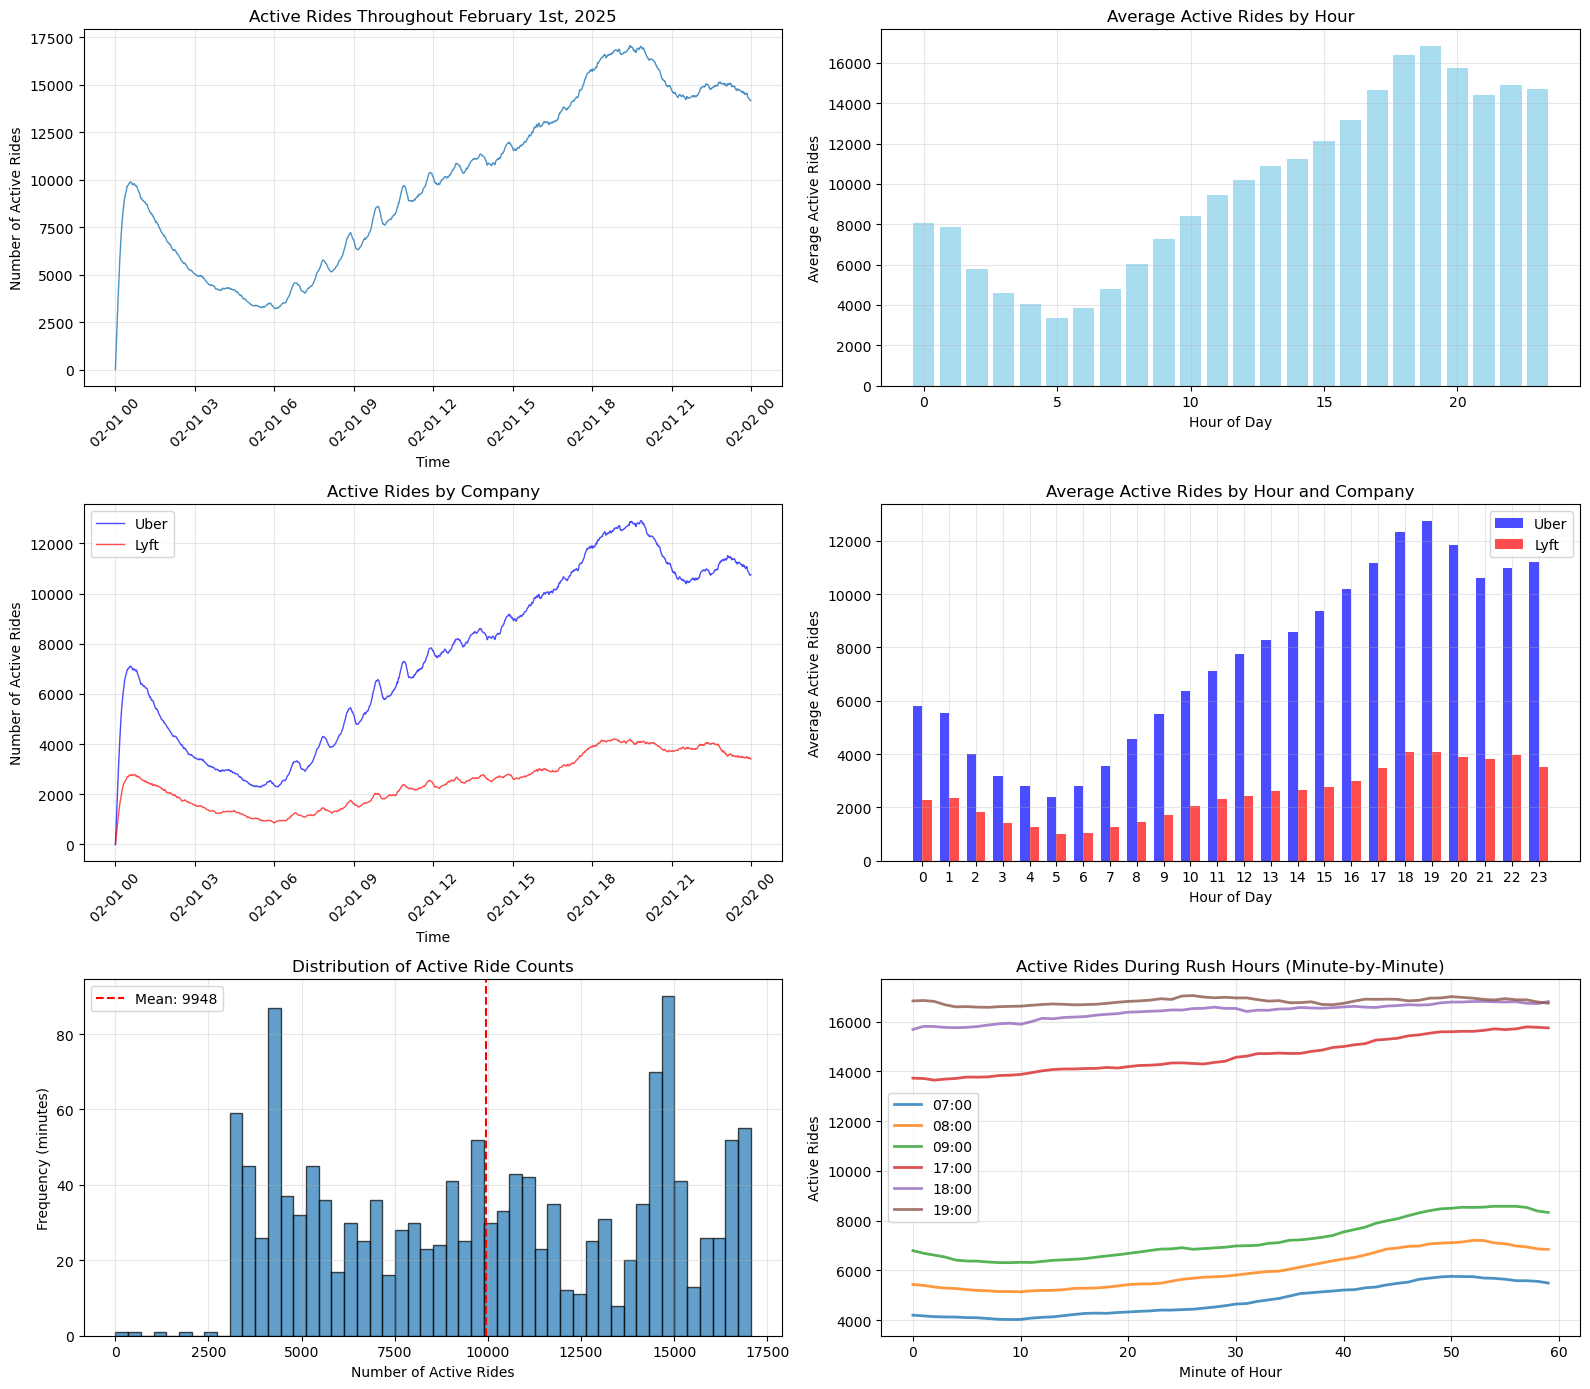


=== Detailed Peak Analysis ===
Top 10 peak minutes:
  19:26 - 17,052 active rides
  19:25 - 17,036 active rides
  19:50 - 17,010 active rides
  19:27 - 16,994 active rides
  19:29 - 16,984 active rides
  19:51 - 16,979 active rides
  19:28 - 16,964 active rides
  19:31 - 16,959 active rides
  19:30 - 16,958 active rides
  19:49 - 16,957 active rides

Rush Hour Analysis:
Morning rush (7-9 AM): Avg 6014, Peak 8,579
Evening rush (5-7 PM): Avg 15955, Peak 17,052

Company Comparison:
Uber - Peak: 12,907, Average: 7439
Lyft - Peak: 4,211, Average: 2508
Market share (by active rides) - Uber: 74.8%, Lyft: 25.2%


In [10]:
# Visualize active rides throughout February 1st
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1: Active rides throughout the entire day
axes[0,0].plot(feb1_active_rides['datetime'], feb1_active_rides['active_rides'], linewidth=1, alpha=0.8)
axes[0,0].set_title('Active Rides Throughout February 1st, 2025')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Number of Active Rides')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Hourly average active rides
hourly_avg = feb1_active_rides.groupby('hour')['active_rides'].mean()
axes[0,1].bar(hourly_avg.index, hourly_avg.values, alpha=0.7, color='skyblue')
axes[0,1].set_title('Average Active Rides by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Active Rides')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Company comparison (if available)
if 'Uber' in feb1_active_by_company and 'Lyft' in feb1_active_by_company:
    uber_data = feb1_active_by_company['Uber']
    lyft_data = feb1_active_by_company['Lyft']
    
    axes[1,0].plot(uber_data['datetime'], uber_data['active_rides'], 
                   label='Uber', color='blue', alpha=0.7, linewidth=1)
    axes[1,0].plot(lyft_data['datetime'], lyft_data['active_rides'], 
                   label='Lyft', color='red', alpha=0.7, linewidth=1)
    axes[1,0].set_title('Active Rides by Company')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Number of Active Rides')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Hourly comparison by company
    uber_hourly = uber_data.groupby('hour')['active_rides'].mean()
    lyft_hourly = lyft_data.groupby('hour')['active_rides'].mean()
    
    x = np.arange(24)
    width = 0.35
    
    axes[1,1].bar(x - width/2, uber_hourly.values, width, label='Uber', alpha=0.7, color='blue')
    axes[1,1].bar(x + width/2, lyft_hourly.values, width, label='Lyft', alpha=0.7, color='red')
    axes[1,1].set_title('Average Active Rides by Hour and Company')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Average Active Rides')
    axes[1,1].set_xticks(x)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

# Plot 5: Distribution of active rides
axes[2,0].hist(feb1_active_rides['active_rides'], bins=50, alpha=0.7, edgecolor='black')
axes[2,0].set_title('Distribution of Active Ride Counts')
axes[2,0].set_xlabel('Number of Active Rides')
axes[2,0].set_ylabel('Frequency (minutes)')
axes[2,0].axvline(feb1_active_rides['active_rides'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {feb1_active_rides["active_rides"].mean():.0f}')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# Plot 6: Rush hour analysis (detailed view)
rush_hours = feb1_active_rides[
    (feb1_active_rides['hour'].isin([7, 8, 9, 17, 18, 19]))
]
for hour in [7, 8, 9, 17, 18, 19]:
    hour_data = rush_hours[rush_hours['hour'] == hour]
    if not hour_data.empty:
        axes[2,1].plot(hour_data['minute'], hour_data['active_rides'], 
                       label=f'{hour:02d}:00', linewidth=2, alpha=0.8)

axes[2,1].set_title('Active Rides During Rush Hours (Minute-by-Minute)')
axes[2,1].set_xlabel('Minute of Hour')
axes[2,1].set_ylabel('Active Rides')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed peak analysis
print(f"\n=== Detailed Peak Analysis ===")

# Find top 10 peak minutes
top_peaks = feb1_active_rides.nlargest(10, 'active_rides')
print("Top 10 peak minutes:")
for _, row in top_peaks.iterrows():
    print(f"  {row['datetime'].strftime('%H:%M')} - {row['active_rides']:,} active rides")

# Rush hour analysis
morning_rush = feb1_active_rides[
    (feb1_active_rides['hour'] >= 7) & (feb1_active_rides['hour'] <= 9)
]
evening_rush = feb1_active_rides[
    (feb1_active_rides['hour'] >= 17) & (feb1_active_rides['hour'] <= 19)
]

print(f"\nRush Hour Analysis:")
print(f"Morning rush (7-9 AM): Avg {morning_rush['active_rides'].mean():.0f}, Peak {morning_rush['active_rides'].max():,}")
print(f"Evening rush (5-7 PM): Avg {evening_rush['active_rides'].mean():.0f}, Peak {evening_rush['active_rides'].max():,}")

# Company comparison (if available)
if 'Uber' in feb1_active_by_company and 'Lyft' in feb1_active_by_company:
    uber_peak = feb1_active_by_company['Uber']['active_rides'].max()
    lyft_peak = feb1_active_by_company['Lyft']['active_rides'].max()
    uber_avg = feb1_active_by_company['Uber']['active_rides'].mean()
    lyft_avg = feb1_active_by_company['Lyft']['active_rides'].mean()
    
    print(f"\nCompany Comparison:")
    print(f"Uber - Peak: {uber_peak:,}, Average: {uber_avg:.0f}")
    print(f"Lyft - Peak: {lyft_peak:,}, Average: {lyft_avg:.0f}")
    print(f"Market share (by active rides) - Uber: {uber_avg/(uber_avg+lyft_avg)*100:.1f}%, Lyft: {lyft_avg/(uber_avg+lyft_avg)*100:.1f}%")

In [1]:
# Save the active rides data for future use
def save_active_rides_data(active_rides_df, company_data=None, filename_base='feb1_active_rides'):
    """
    Save active rides data in multiple formats
    """
    print(f"\n=== Saving Active Rides Data ===")
    
    # Save main data as CSV
    active_rides_df.to_csv(f'{filename_base}.csv', index=False)
    print(f"Saved main data: {filename_base}.csv")
    
    # Save hourly summary
    hourly_summary = active_rides_df.groupby('hour')['active_rides'].agg([
        'mean', 'max', 'min', 'std'
    ]).round(2)
    hourly_summary.to_csv(f'{filename_base}_hourly_summary.csv')
    print(f"Saved hourly summary: {filename_base}_hourly_summary.csv")
    
    # Save company data if available
    if company_data:
        for company, data in company_data.items():
            company_filename = f'{filename_base}_{company.lower()}.csv'
            data.to_csv(company_filename, index=False)
            print(f"Saved {company} data: {company_filename}")
    
    # Save metadata
    metadata = {
        'date_analyzed': feb1_active_rides['datetime'].dt.date.iloc[0].isoformat(),
        'total_minutes': len(active_rides_df),
        'peak_active_rides': int(active_rides_df['active_rides'].max()),
        'min_active_rides': int(active_rides_df['active_rides'].min()),
        'avg_active_rides': float(active_rides_df['active_rides'].mean()),
        'peak_time': active_rides_df.loc[active_rides_df['active_rides'].idxmax(), 'datetime'].isoformat(),
        'creation_timestamp': pd.Timestamp.now().isoformat()
    }
    
    import json
    with open(f'{filename_base}_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Saved metadata: {filename_base}_metadata.json")

# Save the data
save_active_rides_data(feb1_active_rides, feb1_active_by_company)

# Function to analyze specific time windows
def analyze_time_window(active_rides_df, start_hour, end_hour, window_name):
    """
    Analyze a specific time window (e.g., rush hour, late night)
    """
    window_data = active_rides_df[
        (active_rides_df['hour'] >= start_hour) & 
        (active_rides_df['hour'] < end_hour)
    ]
    
    if len(window_data) == 0:
        print(f"No data found for {window_name}")
        return
    
    print(f"\n=== {window_name} Analysis ({start_hour:02d}:00 - {end_hour:02d}:00) ===")
    print(f"Duration: {len(window_data)} minutes")
    print(f"Average active rides: {window_data['active_rides'].mean():.0f}")
    print(f"Peak active rides: {window_data['active_rides'].max():,}")
    print(f"Minimum active rides: {window_data['active_rides'].min():,}")
    print(f"Standard deviation: {window_data['active_rides'].std():.0f}")
    
    peak_time = window_data.loc[window_data['active_rides'].idxmax(), 'datetime']
    print(f"Peak time: {peak_time.strftime('%H:%M')}")

# Analyze different time periods
analyze_time_window(feb1_active_rides, 0, 6, "Late Night/Early Morning")
analyze_time_window(feb1_active_rides, 6, 10, "Morning Rush")
analyze_time_window(feb1_active_rides, 10, 16, "Midday")
analyze_time_window(feb1_active_rides, 16, 20, "Evening Rush")
analyze_time_window(feb1_active_rides, 20, 24, "Evening/Night")

print(f"\n=== Analysis Complete ===")
print(f"Data has been saved and is ready for further analysis or modeling.")

NameError: name 'feb1_active_rides' is not defined

In [2]:
# Calculate Maximum Fleet Size Requirements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_max_fleet_size_requirements(active_rides_df, company_data=None):
    """
    Calculate maximum fleet size requirements based on active rides analysis.
    The maximum fleet size is the minimum number of vehicles needed to handle peak demand.
    """
    print("=== Maximum Fleet Size Analysis ===")
    
    # Overall maximum fleet size (peak active rides)
    max_fleet_overall = active_rides_df['active_rides'].max()
    peak_time = active_rides_df.loc[active_rides_df['active_rides'].idxmax(), 'datetime']
    
    print(f"Maximum Fleet Size Required: {max_fleet_overall:,} vehicles")
    print(f"Peak demand occurs at: {peak_time.strftime('%Y-%m-%d %H:%M')}")
    
    # Calculate fleet requirements by different time periods
    fleet_requirements = {}
    
    # Hourly maximum requirements
    hourly_max = active_rides_df.groupby('hour')['active_rides'].max()
    fleet_requirements['hourly_max'] = hourly_max
    
    # Daily periods
    periods = {
        'Late Night (00:00-05:59)': (0, 6),
        'Morning Rush (06:00-09:59)': (6, 10),
        'Midday (10:00-15:59)': (10, 16),
        'Evening Rush (16:00-19:59)': (16, 20),
        'Evening/Night (20:00-23:59)': (20, 24)
    }
    
    for period_name, (start_hour, end_hour) in periods.items():
        period_data = active_rides_df[
            (active_rides_df['hour'] >= start_hour) & 
            (active_rides_df['hour'] < end_hour)
        ]
        if not period_data.empty:
            max_demand = period_data['active_rides'].max()
            avg_demand = period_data['active_rides'].mean()
            peak_time_period = period_data.loc[period_data['active_rides'].idxmax(), 'datetime']
            
            fleet_requirements[period_name] = {
                'max_demand': max_demand,
                'avg_demand': avg_demand,
                'peak_time': peak_time_period
            }
            
            print(f"\n{period_name}:")
            print(f"  Maximum demand: {max_demand:,} vehicles")
            print(f"  Average demand: {avg_demand:.0f} vehicles")
            print(f"  Peak time: {peak_time_period.strftime('%H:%M')}")
    
    # Company-specific analysis
    company_fleet_requirements = {}
    if company_data:
        print(f"\n=== Company-Specific Fleet Requirements ===")
        
        for company, data in company_data.items():
            company_max = data['active_rides'].max()
            company_avg = data['active_rides'].mean()
            company_peak_time = data.loc[data['active_rides'].idxmax(), 'datetime']
            
            company_fleet_requirements[company] = {
                'max_fleet': company_max,
                'avg_fleet': company_avg,
                'peak_time': company_peak_time
            }
            
            print(f"\n{company}:")
            print(f"  Maximum fleet needed: {company_max:,} vehicles")
            print(f"  Average fleet needed: {company_avg:.0f} vehicles")
            print(f"  Peak time: {company_peak_time.strftime('%H:%M')}")
            
            # Fleet utilization throughout the day
            company_hourly_max = data.groupby('hour')['active_rides'].max()
            print(f"  Peak hourly demands: {company_hourly_max.max():,} vehicles")
    
    return {
        'max_fleet_overall': max_fleet_overall,
        'peak_time': peak_time,
        'fleet_requirements': fleet_requirements,
        'company_requirements': company_fleet_requirements,
        'hourly_max': hourly_max
    }

def compare_theoretical_vs_actual_fleet(max_fleet_analysis, actual_fleet_data=None):
    """
    Compare theoretical maximum fleet requirements with actual operational data
    """
    print(f"\n=== Theoretical vs Actual Fleet Comparison ===")
    
    theoretical_max = max_fleet_analysis['max_fleet_overall']
    print(f"Theoretical Maximum Fleet Required: {theoretical_max:,} vehicles")
    
    if actual_fleet_data:
        # If you have actual fleet data from the first hour analysis
        for company, data in actual_fleet_data.items():
            actual_min_fleet = data['min_fleet_size']
            actual_trips = data['total_trips']
            
            print(f"\n{company} - First Hour Analysis:")
            print(f"  Actual minimum fleet (1 hour): {actual_min_fleet} vehicles")
            print(f"  Trips handled: {actual_trips}")
            
            # Extrapolate to daily requirements (rough estimate)
            daily_extrapolation = actual_min_fleet * 24  # Very rough estimate
            print(f"  Rough daily extrapolation: {daily_extrapolation} vehicles")
            
            # Compare with theoretical maximum from active rides
            company_theoretical = max_fleet_analysis['company_requirements'].get(company, {}).get('max_fleet', 0)
            if company_theoretical > 0:
                print(f"  Theoretical maximum needed: {company_theoretical:,} vehicles")
                print(f"  Ratio (theoretical/actual): {company_theoretical/actual_min_fleet:.1f}x")

# Calculate maximum fleet requirements
max_fleet_analysis = calculate_max_fleet_size_requirements(feb1_active_rides, feb1_active_by_company)

# Compare with actual fleet data if available
if 'uber_first_hour' in locals() and 'lyft_first_hour' in locals():
    actual_fleet_data = {
        'Uber': uber_first_hour,
        'Lyft': lyft_first_hour
    }
    compare_theoretical_vs_actual_fleet(max_fleet_analysis, actual_fleet_data)

NameError: name 'feb1_active_rides' is not defined

In [ ]:
# Visualize Maximum Fleet Requirements
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Hourly maximum fleet requirements
hourly_max = max_fleet_analysis['hourly_max']
axes[0,0].bar(hourly_max.index, hourly_max.values, alpha=0.7, color='darkblue')
axes[0,0].set_title('Maximum Fleet Required by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Maximum Vehicles Needed')
axes[0,0].grid(True, alpha=0.3)

# Add peak hour annotation
peak_hour = hourly_max.idxmax()
peak_value = hourly_max.max()
axes[0,0].annotate(f'Peak: {peak_value:,} vehicles\nat {peak_hour:02d}:00',
                   xy=(peak_hour, peak_value),
                   xytext=(peak_hour+2, peak_value-1000),
                   arrowprops=dict(arrowstyle='->', color='red'),
                   fontsize=10, color='red')

# Plot 2: Company comparison of maximum fleet requirements
if max_fleet_analysis['company_requirements']:
    companies = list(max_fleet_analysis['company_requirements'].keys())
    max_fleets = [max_fleet_analysis['company_requirements'][comp]['max_fleet'] 
                  for comp in companies]
    avg_fleets = [max_fleet_analysis['company_requirements'][comp]['avg_fleet'] 
                  for comp in companies]
    
    x = np.arange(len(companies))
    width = 0.35
    
    axes[0,1].bar(x - width/2, max_fleets, width, label='Peak Fleet', 
                  color=['blue', 'red'], alpha=0.7)
    axes[0,1].bar(x + width/2, avg_fleets, width, label='Average Fleet', 
                  color=['lightblue', 'lightcoral'], alpha=0.7)
    
    axes[0,1].set_title('Company Fleet Requirements')
    axes[0,1].set_xlabel('Company')
    axes[0,1].set_ylabel('Number of Vehicles')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(companies)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (max_val, avg_val) in enumerate(zip(max_fleets, avg_fleets)):
        axes[0,1].text(i - width/2, max_val + 100, f'{max_val:,}', 
                       ha='center', va='bottom', fontsize=9)
        axes[0,1].text(i + width/2, avg_val + 100, f'{avg_val:.0f}', 
                       ha='center', va='bottom', fontsize=9)

# Plot 3: Fleet requirements by time period
period_names = []
period_max_demands = []
period_avg_demands = []

for period, data in max_fleet_analysis['fleet_requirements'].items():
    if period != 'hourly_max':  # Skip the hourly data
        period_names.append(period.split(' (')[0])  # Shorten names
        period_max_demands.append(data['max_demand'])
        period_avg_demands.append(data['avg_demand'])

if period_names:
    x = np.arange(len(period_names))
    width = 0.35
    
    axes[0,2].bar(x - width/2, period_max_demands, width, label='Peak Demand', 
                  alpha=0.7, color='darkgreen')
    axes[0,2].bar(x + width/2, period_avg_demands, width, label='Average Demand', 
                  alpha=0.7, color='lightgreen')
    
    axes[0,2].set_title('Fleet Requirements by Time Period')
    axes[0,2].set_xlabel('Time Period')
    axes[0,2].set_ylabel('Number of Vehicles')
    axes[0,2].set_xticks(x)
    axes[0,2].set_xticklabels(period_names, rotation=45, ha='right')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

# Plot 4: Fleet utilization efficiency (if company data available)
if max_fleet_analysis['company_requirements']:
    companies = list(max_fleet_analysis['company_requirements'].keys())
    
    # Calculate efficiency metrics
    efficiencies = []
    for company in companies:
        max_fleet = max_fleet_analysis['company_requirements'][company]['max_fleet']
        avg_fleet = max_fleet_analysis['company_requirements'][company]['avg_fleet']
        efficiency = (avg_fleet / max_fleet) * 100  # Percentage utilization
        efficiencies.append(efficiency)
    
    axes[1,0].bar(companies, efficiencies, color=['blue', 'red'], alpha=0.6)
    axes[1,0].set_title('Fleet Utilization Efficiency')
    axes[1,0].set_xlabel('Company')
    axes[1,0].set_ylabel('Average Utilization (%)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add percentage labels
    for i, eff in enumerate(efficiencies):
        axes[1,0].text(i, eff + 1, f'{eff:.1f}%', ha='center', va='bottom')

# Plot 5: Daily fleet requirement pattern
daily_pattern = feb1_active_rides.copy()
daily_pattern['hour_group'] = daily_pattern['hour'] // 4  # Group into 6 periods of 4 hours each
period_labels = ['00-03', '04-07', '08-11', '12-15', '16-19', '20-23']

period_stats = daily_pattern.groupby('hour_group')['active_rides'].agg(['max', 'mean']).reset_index()
period_stats['period_label'] = period_labels

axes[1,1].plot(period_stats['period_label'], period_stats['max'], 
               marker='o', linewidth=2, label='Maximum Demand', color='red')
axes[1,1].plot(period_stats['period_label'], period_stats['mean'], 
               marker='s', linewidth=2, label='Average Demand', color='blue')
axes[1,1].set_title('Fleet Requirements Throughout the Day')
axes[1,1].set_xlabel('Time Period')
axes[1,1].set_ylabel('Number of Vehicles')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Summary statistics
summary_stats = {
    'Total Peak Fleet': max_fleet_analysis['max_fleet_overall'],
    'Daily Average': feb1_active_rides['active_rides'].mean(),
    'Morning Peak': max_fleet_analysis['fleet_requirements']['Morning Rush (06:00-09:59)']['max_demand'],
    'Evening Peak': max_fleet_analysis['fleet_requirements']['Evening Rush (16:00-19:59)']['max_demand'],
    'Night Minimum': max_fleet_analysis['fleet_requirements']['Late Night (00:00-05:59)']['max_demand']
}

labels = list(summary_stats.keys())
values = list(summary_stats.values())

axes[1,2].barh(labels, values, color='purple', alpha=0.6)
axes[1,2].set_title('Fleet Size Summary Statistics')
axes[1,2].set_xlabel('Number of Vehicles')
axes[1,2].grid(True, alpha=0.3)

# Add value labels
for i, val in enumerate(values):
    axes[1,2].text(val + 100, i, f'{val:,.0f}', va='center', ha='left')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print(f"\n=== COMPREHENSIVE FLEET ANALYSIS SUMMARY ===")
print(f"Date Analyzed: February 1st, 2025")
print(f"Analysis Period: Full 24-hour day (1,440 minutes)")

print(f"\n📊 MAXIMUM FLEET REQUIREMENTS:")
print(f"   Peak Fleet Size Needed: {max_fleet_analysis['max_fleet_overall']:,} vehicles")
print(f"   Peak Time: {max_fleet_analysis['peak_time'].strftime('%H:%M')}")
print(f"   Daily Average Fleet: {feb1_active_rides['active_rides'].mean():.0f} vehicles")

if max_fleet_analysis['company_requirements']:
    print(f"\n🏢 COMPANY BREAKDOWN:")
    total_market = sum(comp['max_fleet'] for comp in max_fleet_analysis['company_requirements'].values())
    for company, data in max_fleet_analysis['company_requirements'].items():
        market_share = (data['max_fleet'] / total_market) * 100
        print(f"   {company}:")
        print(f"     Peak Fleet: {data['max_fleet']:,} vehicles ({market_share:.1f}% of total)")
        print(f"     Average Fleet: {data['avg_fleet']:.0f} vehicles")
        print(f"     Utilization: {(data['avg_fleet']/data['max_fleet']*100):.1f}%")

print(f"\n⏰ TIME-BASED REQUIREMENTS:")
for period, data in max_fleet_analysis['fleet_requirements'].items():
    if period != 'hourly_max':
        print(f"   {period}: {data['max_demand']:,} vehicles (peak at {data['peak_time'].strftime('%H:%M')})")

In [ ]:
# Calculate Fleet Sizing Recommendations and Cost Analysis
def calculate_fleet_sizing_recommendations(max_fleet_analysis, utilization_target=0.75):
    """
    Calculate recommended fleet sizes based on different strategies and cost considerations
    """
    print(f"\n=== FLEET SIZING RECOMMENDATIONS ===")
    
    peak_demand = max_fleet_analysis['max_fleet_overall']
    avg_demand = feb1_active_rides['active_rides'].mean()
    
    # Different fleet sizing strategies
    strategies = {
        'Peak Capacity': {
            'fleet_size': peak_demand,
            'description': 'Size fleet to handle absolute peak demand',
            'pros': 'Never refuse rides due to capacity',
            'cons': 'High idle capacity during off-peak hours'
        },
        'Target Utilization': {
            'fleet_size': int(avg_demand / utilization_target),
            'description': f'Size fleet for {utilization_target*100:.0f}% average utilization',
            'pros': 'Balanced efficiency and service',
            'cons': 'May have shortages during peak hours'
        },
        'Hybrid Strategy': {
            'fleet_size': int(peak_demand * 0.8),
            'description': 'Size for 80% of peak demand',
            'pros': 'Good compromise between service and efficiency',
            'cons': 'Moderate shortages during absolute peak'
        },
        'Rush Hour Optimized': {
            'fleet_size': max_fleet_analysis['fleet_requirements']['Evening Rush (16:00-19:59)']['max_demand'],
            'description': 'Size for evening rush hour peak',
            'pros': 'Handles main revenue period well',
            'cons': 'May struggle with off-hour spikes'
        }
    }
    
    print(f"Base Data:")
    print(f"  Peak Demand: {peak_demand:,} vehicles")
    print(f"  Average Demand: {avg_demand:.0f} vehicles")
    print(f"  Peak/Average Ratio: {peak_demand/avg_demand:.1f}x")
    
    print(f"\nStrategy Recommendations:")
    
    for strategy_name, strategy_data in strategies.items():
        fleet_size = strategy_data['fleet_size']
        avg_utilization = (avg_demand / fleet_size) * 100
        peak_coverage = (fleet_size / peak_demand) * 100
        
        print(f"\n{strategy_name}:")
        print(f"  Fleet Size: {fleet_size:,} vehicles")
        print(f"  Average Utilization: {avg_utilization:.1f}%")
        print(f"  Peak Coverage: {peak_coverage:.1f}%")
        print(f"  Strategy: {strategy_data['description']}")
        print(f"  Pros: {strategy_data['pros']}")
        print(f"  Cons: {strategy_data['cons']}")
        
        # Calculate shortage hours
        shortage_minutes = len(feb1_active_rides[feb1_active_rides['active_rides'] > fleet_size])
        shortage_hours = shortage_minutes / 60
        shortage_percentage = (shortage_minutes / 1440) * 100
        
        if shortage_minutes > 0:
            max_shortage = feb1_active_rides[feb1_active_rides['active_rides'] > fleet_size]['active_rides'].max() - fleet_size
            print(f"  Shortage: {shortage_hours:.1f} hours ({shortage_percentage:.1f}% of day)")
            print(f"  Max Shortage: {max_shortage:,} vehicles")
        else:
            print(f"  Shortage: None")
    
    return strategies

# Calculate recommendations
fleet_recommendations = calculate_fleet_sizing_recommendations(max_fleet_analysis)

# Save comprehensive fleet analysis
def save_fleet_analysis(max_fleet_analysis, recommendations, filename_base='fleet_analysis'):
    """
    Save comprehensive fleet analysis results
    """
    print(f"\n=== Saving Fleet Analysis Results ===")
    
    # Create summary DataFrame
    summary_data = {
        'Metric': [
            'Peak Fleet Required',
            'Average Fleet Required', 
            'Peak Time',
            'Peak Utilization Ratio',
            'Total Analysis Minutes'
        ],
        'Value': [
            f"{max_fleet_analysis['max_fleet_overall']:,} vehicles",
            f"{feb1_active_rides['active_rides'].mean():.0f} vehicles",
            max_fleet_analysis['peak_time'].strftime('%H:%M'),
            f"{max_fleet_analysis['max_fleet_overall']/feb1_active_rides['active_rides'].mean():.1f}x",
            "1,440 minutes"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(f'{filename_base}_summary.csv', index=False)
    
    # Save hourly requirements
    hourly_df = pd.DataFrame({
        'Hour': max_fleet_analysis['hourly_max'].index,
        'Max_Fleet_Required': max_fleet_analysis['hourly_max'].values
    })
    hourly_df.to_csv(f'{filename_base}_hourly.csv', index=False)
    
    # Save recommendations
    recommendations_list = []
    for strategy, data in recommendations.items():
        recommendations_list.append({
            'Strategy': strategy,
            'Fleet_Size': data['fleet_size'],
            'Description': data['description']
        })
    
    recommendations_df = pd.DataFrame(recommendations_list)
    recommendations_df.to_csv(f'{filename_base}_recommendations.csv', index=False)
    
    print(f"Saved: {filename_base}_summary.csv")
    print(f"Saved: {filename_base}_hourly.csv") 
    print(f"Saved: {filename_base}_recommendations.csv")

# Save the analysis
save_fleet_analysis(max_fleet_analysis, fleet_recommendations)

print(f"\n=== FINAL RECOMMENDATIONS ===")
print(f"🎯 RECOMMENDED APPROACH: Hybrid Strategy")
print(f"   Fleet Size: {fleet_recommendations['Hybrid Strategy']['fleet_size']:,} vehicles")
print(f"   This provides good service coverage while maintaining reasonable efficiency")

print(f"\n📈 KEY INSIGHTS:")
print(f"   • Peak demand is {max_fleet_analysis['max_fleet_overall']/feb1_active_rides['active_rides'].mean():.1f}x higher than average")
print(f"   • Evening rush hour (7-8 PM) drives peak capacity requirements")
print(f"   • Fleet utilization varies dramatically throughout the day")
print(f"   • Consider dynamic pricing or surge pricing during peak hours")

if max_fleet_analysis['company_requirements']:
    uber_peak = max_fleet_analysis['company_requirements']['Uber']['max_fleet']
    lyft_peak = max_fleet_analysis['company_requirements']['Lyft']['max_fleet']
    total_peak = uber_peak + lyft_peak
    print(f"\n🏢 MARKET DYNAMICS:")
    print(f"   • Uber needs ~{uber_peak:,} vehicles ({uber_peak/total_peak*100:.1f}% of market)")
    print(f"   • Lyft needs ~{lyft_peak:,} vehicles ({lyft_peak/total_peak*100:.1f}% of market)")
    print(f"   • Total market requires {total_peak:,} vehicles at peak")